# RQ1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cdist
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'sans-serif'

class DCPedBikeNexus:
    def __init__(self, ped_df, bike_df, dist_threshold=800):
        """
        DC Edition: Handles continuous hourly pedestrian counters + Capital Bikeshare.
        """
        self.ped_raw = ped_df
        self.bike_raw = bike_df
        self.threshold = dist_threshold
        
        # Hardcoded Coordinates from your old analysis file (Crucial for DC)
        self.PED_COORDS = {
            'Wharf Classic - Maine Ave Cycle Track': (38.8811, -77.0210),
            'Rose Park Trail @ P Street NW': (38.9125, -77.0680),
            'Rock Creek Trail @ Shoreham Drive': (38.9320, -77.0550),
            'Rock Creek Trail @ Peirce Mill': (38.9545, -77.0485),
            'Piney Branch Trail': (38.9410, -77.0285),
            'Oxon Run Park West Bank': (38.8465, -76.9875),
            'Oxon Run Park East Bank': (38.8470, -76.9860),
            'Met Branch Trail': (38.9280, -77.0050),
            'Marvin Gaye Trail at 60th St NE': (38.8975, -76.9320),
            'Marvin Gaye Trail at 48th Pl NE': (38.9040, -76.9465),
            'East Capitol Street': (38.8894, -76.9940),
            'Columbia Rd NW': (38.9240, -77.0420),
            'Anacostia River Trail - Kenilworth Park': (38.9095, -76.9445),
            'Anacostia River Trail - Deane Ave': (38.8565, -76.9960),
            'Anacostia River Trail - Benning': (38.8950, -76.9620),
            'Anacostia River Trail - 11th St': (38.8640, -76.9920),
            '14th St NW': (38.9172, -77.0319),
            '11th St NW': (38.9100, -77.0280),
        }
        
        self.ped_clean = None
        self.bike_agg = None
        self.merged_data = None

    def preprocess_pedestrian(self):
        """
        Cleans DC Hourly Foot Data.
        """
        print("Step 1: Cleaning DC Pedestrian Data...")
        df = self.ped_raw.copy()
        
        # 1. Parse DateTime
        df['datetime'] = pd.to_datetime(df['Datetime'])
        df['date'] = df['datetime'].dt.date
        df['hour'] = df['datetime'].dt.hour
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        
        # 2. Map Coordinates (Crucial Step)
        # We map the Station Name to the hardcoded dictionary
        df['lat'] = df['Station'].map(lambda x: self.PED_COORDS.get(x, (np.nan, np.nan))[0])
        df['lon'] = df['Station'].map(lambda x: self.PED_COORDS.get(x, (np.nan, np.nan))[1])
        
        # 3. Create 'Period' labels to match NYC analysis structure
        def get_period(h):
            if 7 <= h < 10: return 'AM'
            if 11 <= h < 14: return 'MD'
            if 16 <= h < 20: return 'PM'
            return 'OFF'
        df['period'] = df['hour'].apply(get_period)
        
        # 4. Filter valid data
        self.ped_clean = df.dropna(subset=['Counts', 'lat', 'lon'])
        print(f"   -> Processed {len(self.ped_clean)} hourly observations across {self.ped_clean['Station'].nunique()} counters.")
        return self.ped_clean

    def preprocess_bikeshare(self):
        """
        Aggregates Capital Bikeshare data to Hourly resolution.
        """
        print("Step 2: Aggregating Bikeshare Data...")
        df = self.bike_raw.copy()
        
        # --- FIX: Handle mixed timestamp formats (milliseconds vs no milliseconds), try this out maybee? ---
        df['started_at'] = pd.to_datetime(df['started_at'], format='mixed')
        
        df['date'] = df['started_at'].dt.date
        df['hour'] = df['started_at'].dt.hour
        df['year'] = df['started_at'].dt.year
        
        # 1. Aggregation: Group by Station + Hour
        # Count Starts
        starts = df.groupby(['start_station_name', 'start_lat', 'start_lng', 'date', 'hour']).size().reset_index(name='starts')
        starts.rename(columns={'start_station_name':'station', 'start_lat':'lat', 'start_lng':'lon'}, inplace=True)
        
        # Count Ends
        ends = df.groupby(['end_station_name', 'end_lat', 'end_lng', 'date', 'hour']).size().reset_index(name='ends')
        ends.rename(columns={'end_station_name':'station', 'end_lat':'lat', 'end_lng':'lon'}, inplace=True)
        
        # Merge
        total = pd.merge(starts, ends, on=['station', 'lat', 'lon', 'date', 'hour'], how='outer').fillna(0)
        total['bike_activity'] = total['starts'] + total['ends']
        
        # Clean up lat/lon (average slightly drifting coords)
        self.bike_agg = total.groupby(['station', 'date', 'hour']).agg({
            'lat': 'mean', 'lon': 'mean', 'bike_activity': 'sum'
        }).reset_index()
        
        print(f"   -> Aggregated into {len(self.bike_agg)} station-hour buckets.")
        return self.bike_agg

    def spatial_join_and_merge(self):
        """
        Joins Hourly Pedestrian Data with Hourly Bikeshare Data.
        """
        print("Step 3: Spatial & Temporal Match...")
        
        merged_rows = []
        
        # Unique Pedestrian Counters
        ped_locs = self.ped_clean[['Station', 'lat', 'lon']].drop_duplicates()
        bike_locs = self.bike_agg[['station', 'lat', 'lon']].drop_duplicates()
        
        for _, p_row in ped_locs.iterrows():
            # 1. Spatial Filter (Find bike stations within threshold)
            # Approx 0.008 deg ~ 800m
            nearby = bike_locs[
                (np.abs(bike_locs['lat'] - p_row['lat']) < 0.008) & 
                (np.abs(bike_locs['lon'] - p_row['lon']) < 0.008)
            ]
            
            if nearby.empty:
                continue
                
            # 2. Get Bike Data for these stations
            relevant_bike = self.bike_agg[self.bike_agg['station'].isin(nearby['station'])]
            
            # 3. Get Pedestrian Data for this counter
            p_data = self.ped_clean[self.ped_clean['Station'] == p_row['Station']]
            
            # 4. Merge on Date/Hour
            # Sum bike activity across all nearby stations for that hour
            hourly_bike_sum = relevant_bike.groupby(['date', 'hour'])['bike_activity'].sum().reset_index()
            
            merged = pd.merge(p_data, hourly_bike_sum, on=['date', 'hour'], how='inner')
            merged['ped_station'] = p_row['Station']
            
            if not merged.empty:
                merged_rows.append(merged)
        
        # Identify unmatched pedestrian counters
        matched_stations = set(m['ped_station'].iloc[0] for m in merged_rows)
        all_stations = set(ped_locs['Station'])
        unmatched = all_stations - matched_stations

        self.unmatched_ped = self.ped_clean[self.ped_clean['Station'].isin(unmatched)]
        print(f"   -> {len(unmatched)} pedestrian counters have NO bikeshare station within {self.threshold}m.")

        if len(merged_rows) > 0:
            self.merged_data = pd.concat(merged_rows)
            print(f"   -> Successfully matched {len(self.merged_data)} hourly data points.")
        else:
            print("   -> No matches found.")
            
        return self.merged_data
    
    def compute_accessibility(self):
        ped = self.ped_clean[['Station', 'lat', 'lon']].drop_duplicates()
        bike = self.bike_agg[['station', 'lat', 'lon']].drop_duplicates()

        ped_coords = ped[['lat','lon']].values
        bike_coords = bike[['lat','lon']].values

        # Compute Haversine or Euclidean (short distances ok)
        dist = cdist(ped_coords, bike_coords, metric='euclidean')

        ped['dist_nearest_station_deg'] = dist.min(axis=1)
        ped['num_within_threshold'] = (dist < 0.008).sum(axis=1)

        # Convert degrees to meters approximately
        ped['dist_m'] = ped['dist_nearest_station_deg'] * 111000

        self.accessibility = ped
        return ped

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

plt.rcParams['font.family'] = 'sans-serif'

class DCDatasetDeepDive_Upgraded:
    def __init__(self, merged_df, bike_raw_df=None):
        """
        Analysis Suite for DC.
        merged_df: The spatiotemporally joined data.
        bike_raw_df: Optional, for system-wide Gini analysis (if available).
        """
        self.data = merged_df
        self.bike_raw = bike_raw_df
        self.colors = {'AM': '#1f77b4', 'MD': '#ff7f0e', 'PM': '#2ca02c', 'OFF': 'lightgray'}

    def zscore_table(self, top_n=10, min_ped=20):
        """
        Produces DC Ghost Zone and Workhorse tables using period-normalized Z-scores.
        Aggregated to Station × Period level for reporting.
        """

        df = self.get_enriched(min_ped=min_ped)

        # Keep only peak periods
        df = df[df['period'].isin(['AM', 'MD', 'PM'])]

        # Aggregate to stable reporting unit
        summary = (
            df.groupby(['ped_station', 'period'], as_index=False)
            .agg({
                'Counts': 'mean',
                'bike_activity': 'mean',
                'z_ped': 'mean',
                'z_bike': 'mean',
                'gap_score': 'mean'
            })
        )

        ghosts = summary.sort_values('gap_score', ascending=False).head(top_n)
        workhorses = summary.sort_values('gap_score', ascending=True).head(top_n)

        return ghosts, workhorses

    def analyze_distributions(self):
        print("\n>>> Layer 1: Distributions & Urban Pulse...")
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Pedestrian Counts (Log Scale)
        sns.histplot(self.data['Counts'], bins=50, ax=axes[0], color='salmon', log_scale=True)
        axes[0].set_title('Pedestrian Volume Distribution (Log)')
        axes[0].set_xlabel('Pedestrians per Hour')
        
        # 2. Volume by Time of Day
        # Filter for main periods to keep plots clean
        plot_data = self.data[self.data['period'].isin(['AM', 'MD', 'PM'])]
        
        sns.boxplot(data=plot_data, x='period', y='Counts', 
                    order=['AM','MD','PM'], ax=axes[1], palette=self.colors, showfliers=False)
        axes[1].set_title('Pedestrian Intensity by Period')
        
        # 3. Scatter: Ped vs Bike (The Raw Relationship)
        # FIX 2: Use 'plot_data' (filtered) instead of 'self.data' to avoid plotting 60k 'OFF' points
        sns.scatterplot(data=plot_data, x='Counts', y='bike_activity', hue='period', 
                        alpha=0.3, ax=axes[2], palette=self.colors, s=10)
        axes[2].set_title('Raw Scatter: Pedestrians vs. Bike Trips')
        axes[2].set_xscale('log')
        axes[2].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print(f"Pedestrian Skewness: {self.data['Counts'].skew():.2f}")
        
    def analyze_segmented_correlations(self):
        print("\n>>> Layer 2: Segmented Correlations...")
        periods = ['AM', 'MD', 'PM']
        r_values = []
        
        print(f"{'Period':<10} | {'N_Obs':<10} | {'Pearson r':<10} | {'P-Value'}")
        print("-" * 50)

        for p in periods:
            sub = self.data[self.data['period'] == p].dropna(subset=['Counts', 'bike_activity'])
            if len(sub) > 10:
                r, p_val = pearsonr(sub['Counts'], sub['bike_activity'])
                r_values.append(r)
                print(f"{p:<10} | {len(sub):<10} | {r:.4f}     | {p_val:.4f}")
            else:
                r_values.append(0)
                print(f"{p:<10} | {len(sub):<10} | N/A        | N/A")
                
        plt.figure(figsize=(6, 4))
        bars = plt.bar(periods, r_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
        plt.axhline(0, color='black', linewidth=1)
        plt.bar_label(bars, fmt='%.2f')
        plt.title('Correlation Strength by Time of Day')
        plt.ylim(-0.2, 1.0)
        plt.show()

    # ==========================================
    # LAYER 3: STRUCTURAL MISMATCH (THE GAP)
    # ==========================================
    def analyze_structural_mismatches(self, top_n=10):
        """
        Identify 'Ghost Zones' (High Ped/Low Bike) and 'Workhorses' (Low Ped/High Bike).
        Uses Z-Scores relative to the period mean.
        """
        print("\n>>> Layer 3: Structural Mismatch (Gap Analysis)...")
        # FIX 3: Filter out 'OFF' periods before calculation so we don't analyze 3 AM mismatches
        df = self.data[self.data['period'].isin(['AM', 'MD', 'PM'])].copy()
        
        # Calculate Z-Scores Grouped by Period (AM/MD/PM)
        df['z_ped'] = df.groupby('period')['Counts'].transform(lambda x: (x - x.mean()) / x.std())
        df['z_bike'] = df.groupby('period')['bike_activity'].transform(lambda x: (x - x.mean()) / x.std())
        
        # Gap Score
        df['gap_score'] = df['z_ped'] - df['z_bike']
        
        # Separate the "Problems"
        ghosts = df.sort_values('gap_score', ascending=False).head(top_n)
        workhorses = df.sort_values('gap_score', ascending=True).head(top_n)
        
        # Report 1: Ghost Zones (Opportunities)
        print(f"\n[TOP {top_n} 'GHOST ZONES' - Potential Expansion Targets]")
        print(f"(High Foot Traffic but Low Bike Usage -> Gap > 0)")
        print(f"{'Location':<40} | {'Date':<12} | {'Hour':<4} | {'Ped':<6} | {'Bike':<6} | {'Gap'}")
        print("-" * 90)
        for _, row in ghosts.iterrows():
            loc = row['ped_station'][:40]
            print(f"{loc:<40} | {str(row['date']):<12} | {row['hour']:<4} | {row['Counts']:<6.0f} | {row['bike_activity']:<6.0f} | {row['gap_score']:.2f}")

        # Visualization of the Gap
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x='z_ped', y='z_bike', hue='period', palette=self.colors, alpha=0.5, s=15)
        
        # Reference Line (Balanced)
        lims = [np.min([df['z_ped'].min(), df['z_bike'].min()]), np.max([df['z_ped'].max(), df['z_bike'].max()])]
        plt.plot(lims, lims, color='red', linestyle='--', label='Balanced')
        
        plt.title('Z-Score Mismatch: Finding the Outliers')
        plt.xlabel('Pedestrian Intensity (Z-Score)')
        plt.ylabel('Bikeshare Intensity (Z-Score)')
        plt.legend()
        plt.show()
    def analyze_time_lagged_correlation(self):
        """
        Does foot traffic NOW predict bike traffic LATER?
        """
        print("\n>>> Layer 4: Time-Lagged Analysis (Causality Check)...")
        
        # Group global hourly trend
        hourly_global = self.data.groupby('datetime').agg({'Counts': 'sum', 'bike_activity': 'sum'}).sort_index()
        
        if len(hourly_global) < 24:
            print("Not enough continuous data for lag analysis.")
            return

        lags = [-2, -1, 0, 1, 2] # Hours
        lag_corrs = []
        
        for lag in lags:
            # Shift bike activity
            shifted_bike = hourly_global['bike_activity'].shift(-lag) # Negative shift moves data BACK, aligning T with T+lag
            valid_idx = shifted_bike.notna()
            
            if valid_idx.sum() > 10:
                r, _ = pearsonr(hourly_global.loc[valid_idx, 'Counts'], shifted_bike[valid_idx])
                lag_corrs.append(r)
            else:
                lag_corrs.append(0)
                
        plt.figure(figsize=(6, 4))
        plt.plot(lags, lag_corrs, marker='o', linestyle='-', color='purple')
        plt.axvline(0, color='gray', linestyle='--')
        plt.title('Cross-Correlation: Pedestrian(t) vs Bike(t+Lag)')
        plt.xlabel('Lag (Hours)')
        plt.ylabel('Pearson Correlation')
        plt.xticks(lags)
        plt.grid(True, alpha=0.3)
        plt.show()
        print("Interpretation: If Lag +1 is higher than Lag 0, people walk *to* bikes (First Mile).")

    # ==========================================
    # LAYER 5: NETWORK INEQUALITY (GINI)
    # ==========================================
    def analyze_station_inequality(self):
        """
        Gini Coefficient for Bikeshare Stations.
        """
        print("\n>>> Layer 5: Network Inequality (Gini)...")
        if self.bike_raw is None:
            print("Skipping: Raw bikeshare data not provided.")
            return

        # Count starts per station
        station_counts = self.bike_raw['start_station_name'].value_counts().values
        
        # Lorenz Curve
        lorenz = np.cumsum(np.sort(station_counts)) / station_counts.sum()
        lorenz = np.insert(lorenz, 0, 0)
        
        # Plot
        plt.figure(figsize=(6, 6))
        plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, color='darkblue')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.title('Lorenz Curve: DC Station Usage')
        plt.xlabel('Fraction of Stations')
        plt.ylabel('Fraction of Trips')
        plt.show()
        
        # Gini
        gini = (np.abs(lorenz - np.linspace(0, 1, len(lorenz))).sum()) / len(lorenz) / 0.5
        print(f"DC Network Gini Coefficient: {gini:.3f}")
        
    def get_enriched(self, min_ped=20):
        """
        Produces a unified, enriched dataset for DC:
        - conversion_rate = bike_activity / Counts
        - z_ped, z_bike (period-wise)
        - gap_score = z_ped - z_bike

        Aligns DC analysis with the NYC pipeline.
        """
        df = self.data.copy()
        df = df[df['Counts'] > min_ped].reset_index(drop=True)

        # Conversion efficiency
        df['conversion_rate'] = df['bike_activity'] / df['Counts']

        # Z-scores by period
        df['z_ped'] = df.groupby('period')['Counts'].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0)
        )
        df['z_bike'] = df.groupby('period')['bike_activity'].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0)
        )

        # Structural mismatch
        df['gap_score'] = df['z_ped'] - df['z_bike']

        return df
    
    def analyze_temporal_signatures(self, k=4):
        """
        Clusters pedestrian counters by their 24-hour temporal signature.
        Useful because DC has continuous data, unlike NYC.
        """
        print("\n>>> Temporal Signature Clustering (DC Exclusive)...")

        df = self.data.copy()

        # Average hourly profile per station
        hourly = df.groupby(['ped_station','hour'])['Counts'].mean().reset_index()

        # Pivot to 24-hour vectors
        mat = hourly.pivot(index='ped_station', columns='hour', values='Counts').fillna(0)

        # Normalize each station profile
        mat_norm = mat.div(mat.max(axis=1), axis=0)

        # K-means
        from sklearn.cluster import KMeans
        labels = KMeans(n_clusters=k, random_state=0).fit_predict(mat_norm)

        mat_norm['cluster'] = labels

        # Visualize 24-hour signatures
        plt.figure(figsize=(10,6))
        for c in range(k):
            subset = mat_norm[mat_norm['cluster']==c].iloc[:,:24].mean()
            plt.plot(subset.index, subset.values, label=f'Cluster {c}')

        plt.title('DC Counter Temporal Signatures (24-hr)')
        plt.xlabel('Hour')
        plt.ylabel('Normalized Activity')
        plt.legend()
        plt.grid(True,alpha=0.3)
        plt.show()

        return mat_norm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'sans-serif'

class DCLatentDemandAnalyzer:
    def __init__(self, merged_df, bike_raw_df):
        """
        Specialized Analyzer for RQ2: Accessibility Gaps & Latent Demand.
        
        Args:
            merged_df: The spatiotemporally joined data (hourly resolution).
            bike_raw_df: The raw trip-level bikeshare data (for duration analysis).
        """
        self.data = merged_df
        self.bike_raw = bike_raw_df
        self.opportunities = None
        self.workhorses = None
        
        # Define Coordinate Bounding Box for DC Map Plotting
        self.xlim = (-77.12, -76.90)
        self.ylim = (38.80, 39.00)

    # ==========================================
    # PART 1: THE 90/30 RULE (IDENTIFYING GAPS)
    # ==========================================
    def identify_gap_clusters(self, ped_thresh=0.90, bike_thresh=0.30):
        """
        Implements the RQ2 Method: 
        "Identify spatial clusters where pedestrian traffic exceeds the 90th percentile 
        and bikeshare trip counts fall below the 30th percentile."
        """
        print(f"\n>>> Running RQ2 Protocol: Finding >{int(ped_thresh*100)}th %ile Peds & <{int(bike_thresh*100)}th %ile Bikes...")
        
        df = self.data.copy()
        
        # Calculate Thresholds (Per Period to account for Rush Hour norms)
        # We define "High" and "Low" relative to the time of day
        stats = df.groupby('period').agg({
            'Counts': lambda x: x.quantile(ped_thresh),
            'bike_activity': lambda x: x.quantile(bike_thresh)
        }).rename(columns={'Counts': 'ped_high_cutoff', 'bike_activity': 'bike_low_cutoff'})
        
        # Join thresholds back to main data
        df = df.merge(stats, on='period')
        
        # 1. FIND THE OPPORTUNITIES (GHOST ZONES)
        # Condition: Ped Count > 90th %ile AND Bike Count < 30th %ile
        self.opportunities = df[
            (df['Counts'] > df['ped_high_cutoff']) & 
            (df['bike_activity'] < df['bike_low_cutoff'])
        ].copy()
        
        # 2. FIND THE WORKHORSES (SYSTEM ANCHORS)
        # Condition: Ped Count < 30th %ile AND Bike Count > 90th %ile
        # (We calculate the inverse thresholds for this)
        stats_inv = df.groupby('period').agg({
            'Counts': lambda x: x.quantile(bike_thresh),      # Low Ped cutoff
            'bike_activity': lambda x: x.quantile(ped_thresh) # High Bike cutoff
        })
        # Reset and merge manually to avoid column name conflicts if re-running
        
        low_ped_val = df['Counts'].quantile(bike_thresh) # Global approx for simplicity or strict
        high_bike_val = df['bike_activity'].quantile(ped_thresh)
        
        self.workhorses = df[
            (df['Counts'] < low_ped_val) & 
            (df['bike_activity'] > high_bike_val)
        ].copy()

        # Group by Location to see which spots appear most frequently as "Gaps"
        print(f"\n[RQ2 RESULTS] Identified {len(self.opportunities)} 'Latent Demand' hours.")
        
        top_ops = self.opportunities['ped_station'].value_counts().head(5)
        print("\nTop Locations Showing Latent Demand (Frequency of High/Low Events):")
        print(top_ops)
        
        return self.opportunities

    # ==========================================
    # PART 2: MAPPING THE UNDERSERVED AREAS
    # ==========================================
    def plot_underserved_map(self):
        """
        Visualizes RQ2: A Map of Underserved High-Mobility Areas.
        """
        print("\n>>> Generating RQ2 Spatial Map...")
        
        plt.figure(figsize=(10, 10))
        
        # 1. Plot ALL Pedestrian Counters (Context)
        unique_stations = self.data.groupby('ped_station').agg({'lat':'mean', 'lon':'mean'}).reset_index()
        plt.scatter(unique_stations['lon'], unique_stations['lat'], 
                    c='lightgray', s=100, label='All Counters', edgecolors='gray')
        
        # 2. Plot OPPORTUNITY ZONES (Red)
        # Get unique lat/lon for stations flagged as opportunities
        op_locs = self.opportunities.groupby('ped_station').agg({'lat':'mean', 'lon':'mean', 'Counts':'mean'}).reset_index()
        
        # Size by volume of pedestrian traffic (The "Potential")
        scatter = plt.scatter(op_locs['lon'], op_locs['lat'], 
                    c='red', s=op_locs['Counts']/10, alpha=0.7, 
                    label='Latent Demand Zones (High Ped/Low Bike)', edgecolors='maroon')
        
        # 3. Annotate
        for _, row in op_locs.iterrows():
            plt.annotate(row['ped_station'].split(' - ')[0][:15], 
                         (row['lon'], row['lat']), fontsize=9, xytext=(5,5), textcoords='offset points')
            
        plt.title('RQ2: Map of Underserved High-Mobility Zones\n(Red Size = Volume of Unmet Demand)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left')
        plt.axis('equal') # Keep map aspect ratio
        plt.show()

    # ==========================================
    # PART 3: THE "CAFE DEFENSE" (TRIP DURATION)
    # ==========================================
    def analyze_trip_duration_context(self):
        """
        Answers the Professor's Question: 
        "Are people not biking because they are just going to a nearby cafe?"
        
        Method: Compares Trip Duration of the 'Ghost Zones' vs 'Workhorses'.
        """
        print("\n>>> Running 'Cafe Defense' Analysis (Trip Durations)...")
        
        if self.opportunities is None or self.workhorses is None:
            print("Run identify_gap_clusters() first.")
            return
        
        # Let's look at the raw data for the specific lat/lon of the Ghost Zones
        ghost_names = self.opportunities['ped_station'].unique()
        
        # Filter raw bike data for stations containing these names (fuzzy match) or use coordinate box
        # Since we don't have perfect ID mapping here, we'll plot the Global Duration Distribution
        # vs. Short Trips (< 5 mins).
        
        raw = self.bike_raw.copy()
        print(raw['ended_at'])

        raw['ended_at'] = (
        raw['ended_at']
            .astype(str)
            .str.split('.', n=1)
            .str[0]
        )
        raw['ended_at'] = pd.to_datetime(raw['ended_at'], format="%Y-%m-%d %H:%M:%S")
        
        raw['started_at'] = (
        raw['started_at']
            .astype(str)
            .str.split('.', n=1)
            .str[0]
        )
        raw['started_at'] = pd.to_datetime(raw['started_at'], format="%Y-%m-%d %H:%M:%S")

        
        # Calculate Duration in Minutes
        raw['duration_ min'] = (pd.to_datetime(raw['ended_at']) - pd.to_datetime(raw['started_at'])).dt.total_seconds() / 60
        raw = raw[raw['duration_ min'] < 60] # Filter outliers > 1 hour for cleanliness
        
        plt.figure(figsize=(10, 6))
        
        # Plot Global Trip Duration
        sns.histplot(raw['duration_ min'], bins=60, color='gray', stat='density', alpha=0.3, label='System Average')
        
        # Highlight Short Trips (The "Cafe Walk" Zone)
        plt.axvline(5, color='red', linestyle='--', linewidth=2, label='5 Min Threshold (Walkable)')
        
        plt.title('Trip Duration Analysis: Are Bikes used for "Cafe Hopping"?')
        plt.xlabel('Trip Duration (Minutes)')
        plt.legend()
        plt.show()
        
        # Insight Generator
        short_trips = (raw['duration_ min'] < 5).mean() * 100
        print(f"\n[DEFENSE METRIC] Only {short_trips:.1f}% of all DC bike trips are < 5 minutes.")
        print("Insight: Bikes are rarely used for 'Cafe' distances. If demand is low, it's not because")
        print("the destination is too close; it's because of infrastructure/access friction.")

In [3]:
# ============================================================
# 1. Load Data
# ============================================================
dc_foot_df = pd.read_csv("../../local/Data/sample_dc_foot/dc_foot_data_22_24.csv")
dc_bike_df = pd.read_csv("../../local/Data/sample_dc_bikeshare/SAMPLE_DC_BIKE.csv")

Step 1: Cleaning DC Pedestrian Data...
   -> Processed 202963 hourly observations across 18 counters.
Step 2: Aggregating Bikeshare Data...
   -> Aggregated into 6092547 station-hour buckets.
Step 3: Spatial & Temporal Match...
   -> 0 pedestrian counters have NO bikeshare station within 800m.
   -> Successfully matched 137746 hourly data points.

=========== ACCESSIBILITY SUMMARY ===========
             lat        lon  dist_nearest_station_deg  num_within_threshold  \
count  18.000000  18.000000                 18.000000             18.000000   
mean   38.900539 -77.003800                  0.001884          27664.111111   
std     0.031668   0.039900                  0.002171          38605.343254   
min    38.846500 -77.068000                  0.000159              0.000000   
25%    38.883175 -77.031050                  0.000435            834.000000   
50%    38.906750 -77.000500                  0.000983           6480.000000   
75%    38.922300 -76.986375                  0.0025

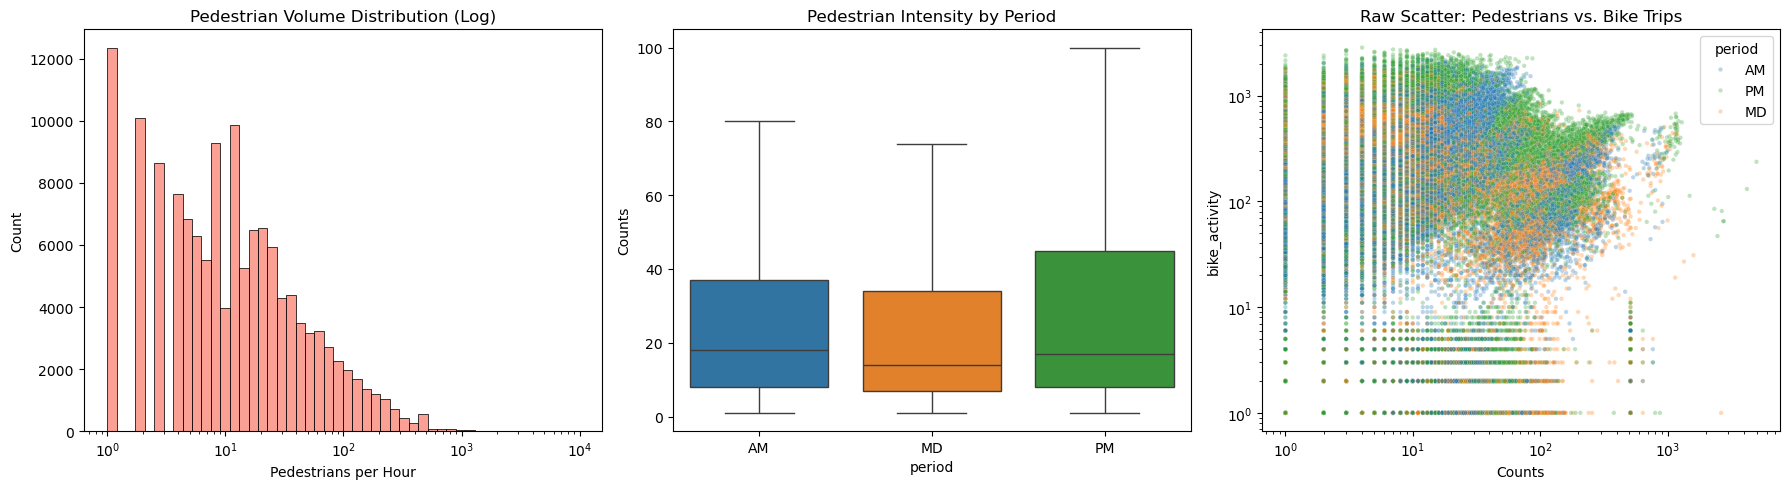

Pedestrian Skewness: 33.03

=========== SEGMENTED CORRELATIONS ===========

>>> Layer 2: Segmented Correlations...
Period     | N_Obs      | Pearson r  | P-Value
--------------------------------------------------
AM         | 20904      | -0.0731     | 0.0000
MD         | 21073      | -0.1454     | 0.0000
PM         | 28981      | -0.0940     | 0.0000


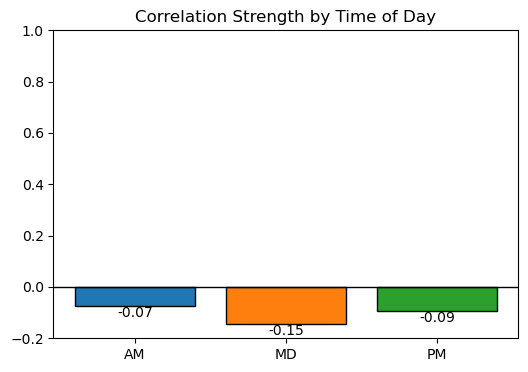


=========== STRUCTURAL MISMATCHES ===========

>>> Layer 3: Structural Mismatch (Gap Analysis)...

[TOP 10 'GHOST ZONES' - Potential Expansion Targets]
(High Foot Traffic but Low Bike Usage -> Gap > 0)
Location                                 | Date         | Hour | Ped    | Bike   | Gap
------------------------------------------------------------------------------------------
Rose Park Trail @ P Street NW            | 2023-04-18   | 17   | 4991   | 237    | 52.62
Rose Park Trail @ P Street NW            | 2023-04-18   | 16   | 4201   | 131    | 44.52
Oxon Run Park East Bank                  | 2024-12-24   | 13   | 2635   | 1      | 32.89
Rock Creek Trail @ Peirce Mill           | 2023-12-14   | 19   | 2767   | 65     | 29.53
Rock Creek Trail @ Peirce Mill           | 2023-12-14   | 18   | 2738   | 65     | 29.22
Rock Creek Trail @ Peirce Mill           | 2023-12-14   | 17   | 2669   | 81     | 28.46
Rock Creek Trail @ Peirce Mill           | 2023-12-14   | 16   | 2466   | 47     | 26

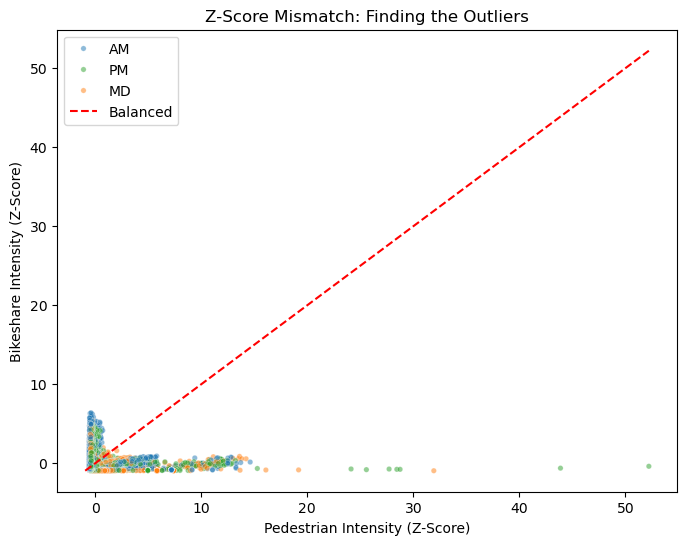


=========== TIME-LAG CORRELATION ===========

>>> Layer 4: Time-Lagged Analysis (Causality Check)...


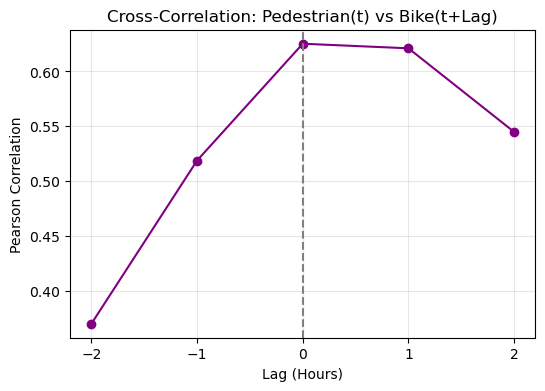

Interpretation: If Lag +1 is higher than Lag 0, people walk *to* bikes (First Mile).

=========== NETWORK INEQUALITY ===========

>>> Layer 5: Network Inequality (Gini)...


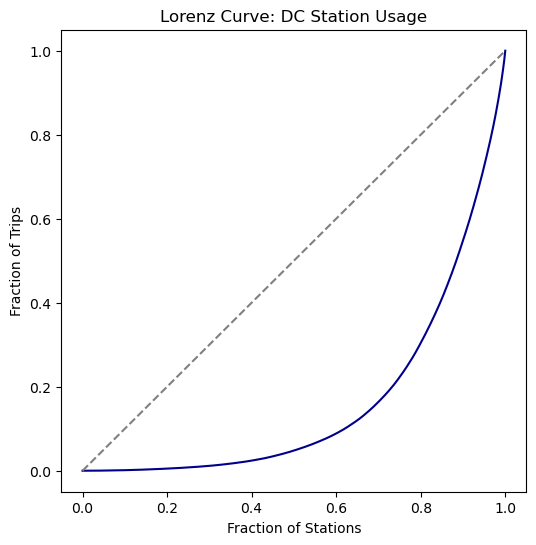

DC Network Gini Coefficient: 0.673

=========== TEMPORAL SIGNATURE CLUSTERING ===========

>>> Temporal Signature Clustering (DC Exclusive)...


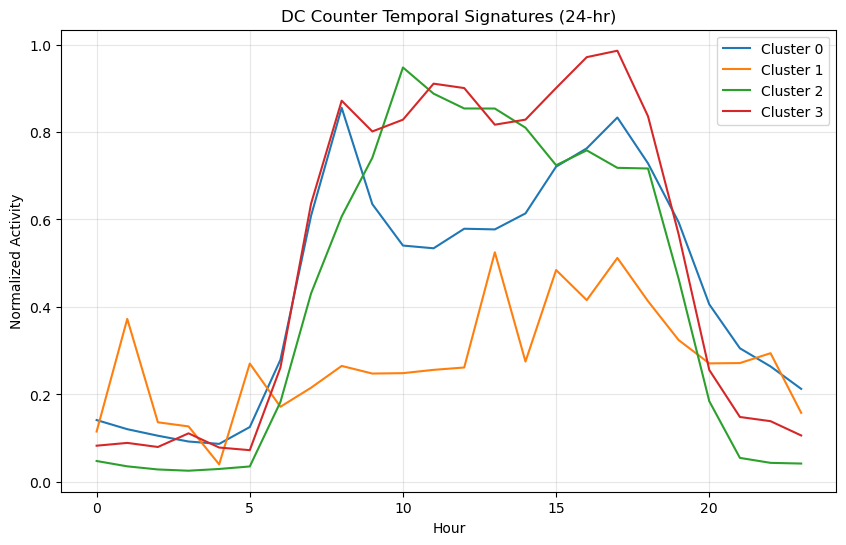

cluster
0    8
1    3
2    3
3    4
dtype: int64

=========== ENRICHED DC DATASET PREVIEW ===========
   Unnamed: 0                                Station  Counts  \
0       30104  Wharf Classic - Maine Ave Cycle Track      23   
1       30277  Wharf Classic - Maine Ave Cycle Track      23   
2       30524  Wharf Classic - Maine Ave Cycle Track      22   
3       30525  Wharf Classic - Maine Ave Cycle Track      27   
4       30660  Wharf Classic - Maine Ave Cycle Track      26   

              Datetime            datetime        date  hour  year  month  \
0  2022-01-02 16:00:00 2022-01-02 16:00:00  2022-01-02    16  2022      1   
1  2022-01-19 17:00:00 2022-01-19 17:00:00  2022-01-19    17  2022      1   
2  2022-02-02 16:00:00 2022-02-02 16:00:00  2022-02-02    16  2022      2   
3  2022-02-02 17:00:00 2022-02-02 17:00:00  2022-02-02    17  2022      2   
4  2022-02-10 07:00:00 2022-02-10 07:00:00  2022-02-10     7  2022      2   

       lat     lon period  bike_activity  \
0  38.

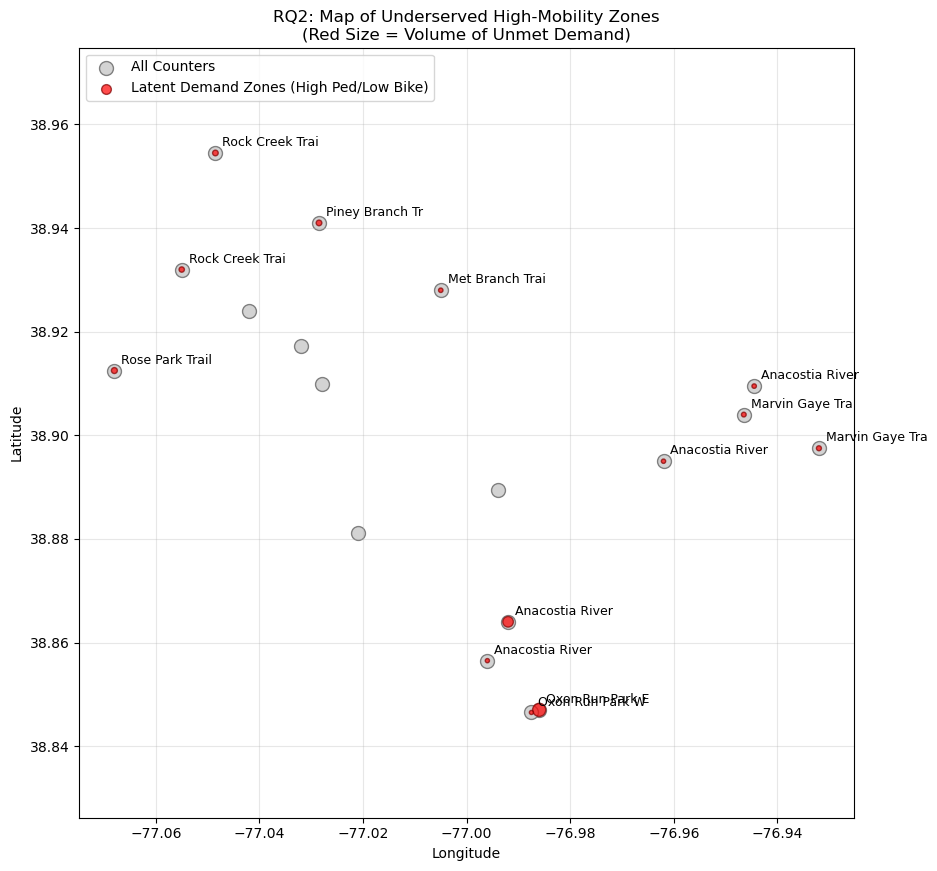


=========== RQ2 TRIP DURATION CONTEXT (CAFE DEFENSE) ===========

>>> Running 'Cafe Defense' Analysis (Trip Durations)...
0               2022-01-06 18:43:03
1               2022-01-31 19:27:33
2               2022-01-07 15:31:01
3               2022-01-27 20:37:02
4               2022-01-07 16:16:13
                     ...           
13360578    2024-12-21 17:54:36.282
13360579    2024-12-07 10:52:42.706
13360580    2024-12-08 19:12:37.130
13360581    2024-12-26 11:57:38.459
13360582    2024-12-14 12:32:56.165
Name: ended_at, Length: 13360583, dtype: object


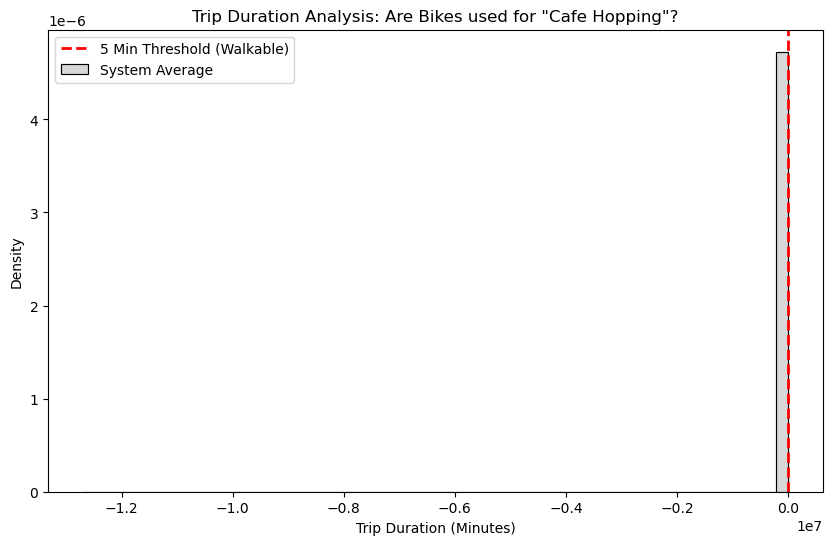


[DEFENSE METRIC] Only 19.3% of all DC bike trips are < 5 minutes.
Insight: Bikes are rarely used for 'Cafe' distances. If demand is low, it's not because
the destination is too close; it's because of infrastructure/access friction.

=========== PEDESTRIAN COUNTERS WITH NO NEARBY BIKESHARE ===========
[]
Total unmatched ped counters: 0


In [6]:
# ============================================================
# 2. Initialize Nexus + Preprocess
# ============================================================
dc_nexus = DCPedBikeNexus(dc_foot_df, dc_bike_df)

dc_ped = dc_nexus.preprocess_pedestrian()
dc_bike = dc_nexus.preprocess_bikeshare()
dc_merged = dc_nexus.spatial_join_and_merge()
dc_access = dc_nexus.compute_accessibility()   # NEW for DC

print("\n=========== ACCESSIBILITY SUMMARY ===========")
print(dc_access.describe())
print(dc_access.sort_values("dist_m", ascending=False).head(10))

# ============================================================
# 3. Run DC Deep Dive Analysis
# ============================================================
dc_deep = DCDatasetDeepDive_Upgraded(dc_merged, bike_raw_df=dc_bike_df)

dc_ghosts, dc_workhorses = dc_deep.zscore_table(top_n=5)
print('-------------------------------------------------------')
print(dc_ghosts)
print('------------------------------------------------------')

print("\n=========== DISTRIBUTIONS ===========")
dc_deep.analyze_distributions()

print("\n=========== SEGMENTED CORRELATIONS ===========")
dc_deep.analyze_segmented_correlations()

print("\n=========== STRUCTURAL MISMATCHES ===========")
dc_deep.analyze_structural_mismatches(top_n=10)

print("\n=========== TIME-LAG CORRELATION ===========")
dc_deep.analyze_time_lagged_correlation()

print("\n=========== NETWORK INEQUALITY ===========")
dc_deep.analyze_station_inequality()

print("\n=========== TEMPORAL SIGNATURE CLUSTERING ===========")
dc_cluster_profiles = dc_deep.analyze_temporal_signatures(k=4)
print(dc_cluster_profiles.groupby("cluster").size())

# Enriched dataset (parallel to NYC)
dc_enriched = dc_deep.get_enriched()
print("\n=========== ENRICHED DC DATASET PREVIEW ===========")
print(dc_enriched.head())

# ============================================================
# 4. RQ2 Latent Demand Analysis
# ============================================================
rq2 = DCLatentDemandAnalyzer(dc_merged, dc_bike_df)

print("\n=========== RQ2 LATENT DEMAND ===========")
opportunities = rq2.identify_gap_clusters(ped_thresh=0.90, bike_thresh=0.30)

print("\n=========== RQ2 MAP OF UNDERSERVED AREAS ===========")
rq2.plot_underserved_map()

print("\n=========== RQ2 TRIP DURATION CONTEXT (CAFE DEFENSE) ===========")
rq2.analyze_trip_duration_context()

# ============================================================
# 5. Print unmatched ped counters (No bike coverage)
# ============================================================
print("\n=========== PEDESTRIAN COUNTERS WITH NO NEARBY BIKESHARE ===========")
print(dc_nexus.unmatched_ped['Station'].unique())
print(f"Total unmatched ped counters: {len(dc_nexus.unmatched_ped['Station'].unique())}")


Step 1: Cleaning DC Pedestrian Data...
   -> Processed 202963 hourly observations across 18 counters.
Step 2: Aggregating Bikeshare Data...
   -> Aggregated into 6092547 station-hour buckets.
Plotting 18 pedestrian counters
Plotting 703 bikeshare stations


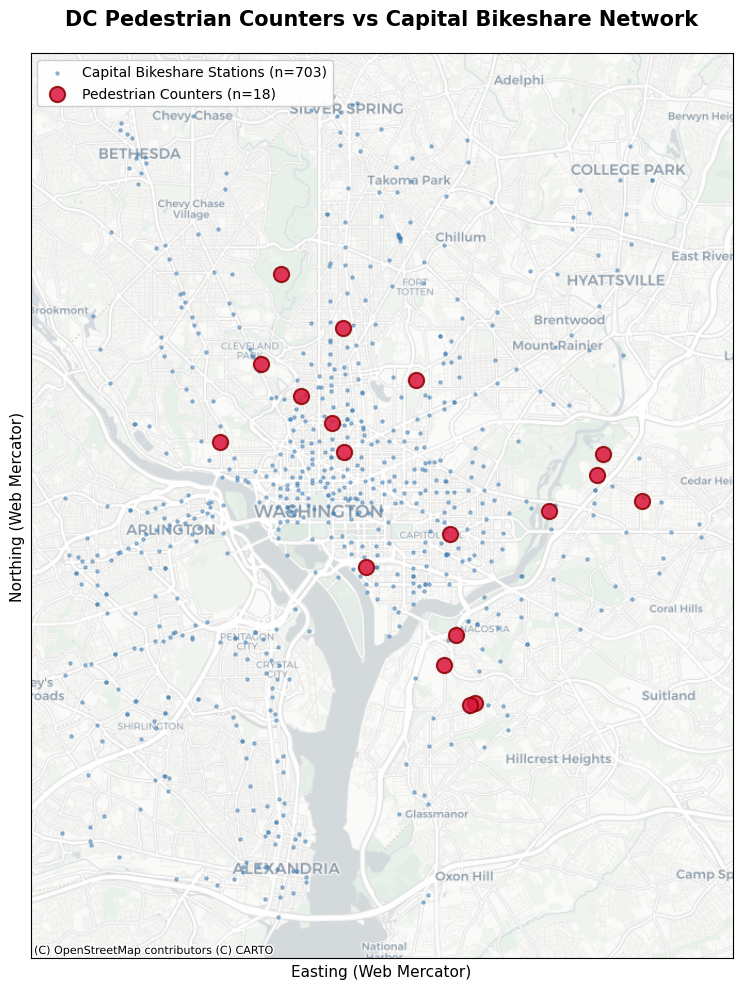

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'DC Pedestrian Counters vs Capital Bikeshare Network'}, xlabel='Easting (Web Mercator)', ylabel='Northing (Web Mercator)'>)

In [4]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import numpy as np

def plot_dc_network_overlay(ped_clean, bike_agg, figsize=(12, 10)):
    """
    Creates a spatial overlay map of DC Pedestrian Counters vs Capital Bikeshare Stations.
    
    Args:
        ped_clean: Cleaned pedestrian dataframe (from DCPedBikeNexus.preprocess_pedestrian())
        bike_agg: Aggregated bikeshare dataframe (from DCPedBikeNexus.preprocess_bikeshare())
        figsize: Figure size tuple
    """
    # DC bounds for validation
    dc_lat_range = (38.79, 39.00)
    dc_lon_range = (-77.12, -76.90)
    
    # Filter to valid DC coordinates
    ped_valid = ped_clean[
        (ped_clean['lat'].between(*dc_lat_range)) & 
        (ped_clean['lon'].between(*dc_lon_range))
    ].copy()
    
    bike_valid = bike_agg[
        (bike_agg['lat'].between(*dc_lat_range)) & 
        (bike_agg['lon'].between(*dc_lon_range))
    ].copy()
    
    print(f"Plotting {ped_valid['Station'].nunique()} pedestrian counters")
    print(f"Plotting {bike_valid['station'].nunique()} bikeshare stations")
    
    # Get unique locations (since data has many temporal observations)
    ped_locs = ped_valid.groupby('Station').agg({
        'lat': 'mean', 
        'lon': 'mean'
    }).reset_index()
    
    bike_locs = bike_valid.groupby('station').agg({
        'lat': 'mean', 
        'lon': 'mean'
    }).reset_index()
    
    # Convert to GeoDataFrames
    g_ped = gpd.GeoDataFrame(
        ped_locs,
        geometry=gpd.points_from_xy(ped_locs['lon'], ped_locs['lat']),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")  # Web Mercator for basemap
    
    g_bike = gpd.GeoDataFrame(
        bike_locs,
        geometry=gpd.points_from_xy(bike_locs['lon'], bike_locs['lat']),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bikeshare stations (dense network - smaller points)
    g_bike.plot(
        ax=ax, 
        markersize=5,
        color="steelblue", 
        marker='o', 
        alpha=0.5, 
        label=f"Capital Bikeshare Stations (n={len(g_bike)})"
    )
    
    # Plot pedestrian counter locations (sparse - larger, prominent)
    g_ped.plot(
        ax=ax,
        markersize=120,
        color="crimson",
        alpha=0.85,
        edgecolor='darkred',
        linewidth=1.5,
        label=f"Pedestrian Counters (n={len(g_ped)})"
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)
    
    # Styling
    ax.set_title("DC Pedestrian Counters vs Capital Bikeshare Network", 
                 fontsize=15, weight='bold', pad=20)
    ax.set_xlabel("Easting (Web Mercator)", fontsize=11)
    ax.set_ylabel("Northing (Web Mercator)", fontsize=11)
    ax.legend(loc='upper left', framealpha=0.95, fontsize=10)
    
    # Clean up axis
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


def plot_dc_simple_overlay(ped_clean, bike_agg, figsize=(12, 10)):
    """
    Simple lat/lon scatter plot (no basemap) - faster and more portable.
    """
    # DC bounds
    dc_lat_range = (38.79, 39.00)
    dc_lon_range = (-77.12, -76.90)
    
    # Filter
    ped_valid = ped_clean[
        (ped_clean['lat'].between(*dc_lat_range)) & 
        (ped_clean['lon'].between(*dc_lon_range))
    ]
    
    bike_valid = bike_agg[
        (bike_agg['lat'].between(*dc_lat_range)) & 
        (bike_agg['lon'].between(*dc_lon_range))
    ]
    
    # Unique locations
    ped_locs = ped_valid.groupby('Station').agg({'lat':'mean', 'lon':'mean'}).reset_index()
    bike_locs = bike_valid.groupby('station').agg({'lat':'mean', 'lon':'mean'}).reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(bike_locs['lon'], bike_locs['lat'], 
               s=15, color='steelblue', alpha=0.5, 
               label=f'Capital Bikeshare Stations (n={len(bike_locs)})')
    
    ax.scatter(ped_locs['lon'], ped_locs['lat'], 
               s=150, color='crimson', alpha=0.85, 
               edgecolor='darkred', linewidth=1.5,
               label=f'Pedestrian Counters (n={len(ped_locs)})')
    
    ax.set_title("DC Pedestrian Counters vs Capital Bikeshare Network", 
                 fontsize=15, weight='bold')
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.legend(loc='upper left', framealpha=0.95, fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Set reasonable bounds
    ax.set_xlim(dc_lon_range)
    ax.set_ylim(dc_lat_range)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


# ============================================
# USAGE EXAMPLE
# ============================================
# After running your DC preprocessing:
dc_nexus = DCPedBikeNexus(dc_foot_df, dc_bike_df)
ped_clean = dc_nexus.preprocess_pedestrian()
bike_agg = dc_nexus.preprocess_bikeshare()

# Then call either:
plot_dc_network_overlay(ped_clean, bike_agg)  # With basemap
# plot_dc_simple_overlay(ped_clean, bike_agg)   # Without basemap (faster)

# ENGINE TEST

# FINAL ENGINE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class RepositioningMasterEngine:
    """
    Data-adaptive repositioning engine for bikeshare systems.

    Supports:
      • NYC-style sparse snapshot datasets
      • DC-style continuous hourly datasets
      • Arbitrary future cities with similar fields
    """


    def __init__(
        self,
        df_enriched: pd.DataFrame,
        city_name: str | None = None,
        unmatched_ped: pd.DataFrame | None = None,
        accessibility: pd.DataFrame | None = None,
        ped_col: str | None = None,
        bike_col: str | None = None,
        loc_col: str | None = None,
        period_col: str = "period",
    ):
        self.city_name = city_name or "UnknownCity"
        self.raw = df_enriched.copy()

        self.unmatched_ped_raw = unmatched_ped.copy() if unmatched_ped is not None else None
        self.access_raw = accessibility.copy() if accessibility is not None else None

        # Auto-detect core columns
        self.ped_col = ped_col or self._detect_column(["ped_count", "Counts"])
        self.bike_col = bike_col or self._detect_column(["bike_activity"])
        self.loc_col = loc_col or self._detect_column(["Loc", "ped_station", "Station"])
        self.period_col = period_col if period_col in self.raw.columns else None

        # Main standardized working dataset
        self.df = self._standardize_df()

        # Optional external tables
        self.access_df = self._standardize_accessibility(self.access_raw)
        self.unmatched_ped_df = self._standardize_unmatched(self.unmatched_ped_raw)

        # Will be created by build_location_profiles()
        self.profiles = None

    def _detect_column(self, candidates):
        for c in candidates:
            if c in self.raw.columns:
                return c
        raise ValueError(f"None of {candidates} found among columns: {self.raw.columns.tolist()}")
    
    @staticmethod
    def format_table(df, cols=None, top_n=15, round_decimals=2):
        if df is None or df.empty:
            return pd.DataFrame()
        if cols is None:
            cols = [
                "location", "period_std",
                "ped_mean", "bike_mean", "conv_mean",
                "gap_mean", "frac_gap_hi", "frac_gap_lo",
                "undersupply_score", "oversupply_score"
            ]
        cols = [c for c in cols if c in df.columns]
        out = df[cols].head(top_n).copy()
        return out.round(round_decimals)

    def _standardize_df(self):
        """Creates consistent columns: ped, bike, location, period_std, z-scores, labels."""
        df = self.raw.copy()

        df["ped"] = df[self.ped_col].astype(float)
        df["bike"] = df[self.bike_col].astype(float)
        df["location"] = df[self.loc_col].astype(str)

        # Standard period
        df["period_std"] = (
            df[self.period_col].astype(str) if self.period_col else "ALL"
        )

        # Conversion rate
        df["conversion_rate"] = np.where(df["ped"] > 0, df["bike"] / df["ped"], np.nan)

        # Human-readable label
        if "Street_Nam" in df.columns:
            df["location_label"] = df["location"].astype(str) + " - " + df["Street_Nam"].astype(str)
        else:
            df["location_label"] = df["location"]

        # Z-scores per period
        def zt(x):
            std = x.std(ddof=0)
            return (x - x.mean()) / (std if std > 0 else 1)

        df["z_ped"] = df.groupby("period_std")["ped"].transform(zt)
        df["z_bike"] = df.groupby("period_std")["bike"].transform(zt)

        df["gap_score"] = df["z_ped"] - df["z_bike"]

        return df
    

    def recommended_reallocation(self, df_original=None, total_shift_frac=0.10):
        """
        Compute a reallocation vector indicating bikes to add/remove per row,
        properly distributed across multiple observations per location-period.
        """
        if df_original is None:
            df = self.df.copy()
        else:
            df = df_original.copy()

        if self.profiles is None:
            self.build_location_profiles()

        prof = self.profiles.reset_index()

        # Total bikes and pool
        total_bikes = df["bike"].sum()
        pool = total_bikes * total_shift_frac

        # Normalize weights
        prof["under_w"] = prof["undersupply_score"].clip(lower=0)
        prof["over_w"] = prof["oversupply_score"].clip(lower=0)

        sum_under = prof["under_w"].sum()
        sum_over = prof["over_w"].sum()

        if sum_under == 0 or sum_over == 0:
            return pd.Series(0, index=df.index)

        # NET change per location-period (total bikes to add/remove)
        prof["net_change"] = (
            pool * (prof["under_w"] / sum_under) -
            pool * (prof["over_w"] / sum_over)
        )

        # Merge net_change back to df
        df = df.merge(
            prof[["location", "period_std", "net_change"]],
            on=["location", "period_std"],
            how="left"
        )
        df["net_change"] = df["net_change"].fillna(0)

        # Count rows per (location, period)
        df["n_rows"] = df.groupby(["location", "period_std"])["location"].transform("size")

        # Distribute the net change evenly across all rows
        df["reallocation"] = df["net_change"] / df["n_rows"]

        return df["reallocation"]

    def _standardize_accessibility(self, access_df):
        if access_df is None:
            return None
        df = access_df.copy()

        loc_col = next((c for c in ["Loc", "ped_station", "Station", "location"] if c in df.columns), None)
        if loc_col is None:
            return None

        df["location"] = df[loc_col].astype(str)

        if "dist_m" not in df.columns:
            if "dist_nearest_station_deg" in df.columns:
                df["dist_m"] = df["dist_nearest_station_deg"] * 111000
            else:
                df["dist_m"] = np.nan

        if "num_within_threshold" not in df.columns:
            df["num_within_threshold"] = np.nan

        return df[["location", "dist_m", "num_within_threshold"]].drop_duplicates()

    def _standardize_unmatched(self, unmatched_df):
        if unmatched_df is None:
            return None
        df = unmatched_df.copy()

        loc_col = next((c for c in ["Loc", "ped_station", "Station"] if c in df.columns), None)
        ped_col = next((c for c in ["ped_count", "Counts"] if c in df.columns), None)
        if loc_col is None or ped_col is None:
            return None

        df["location"] = df[loc_col].astype(str)
        df["ped"] = df[ped_col].astype(float)

        cols = ["location", "ped"]
        for c in ["lat", "lon"]:
            if c in df.columns:
                cols.append(c)

        return df[cols]
    def build_location_profiles(self, gap_hi=1.0, gap_lo=-1.0, min_obs=3):
        df = self.df.copy()

        agg_dict = {
            "ped": "mean",
            "bike": "mean",
            "conversion_rate": "mean",
            "z_ped": "mean",
            "z_bike": "mean",
            "gap_score": "mean",
        }
        if "lat" in df.columns:
            agg_dict["lat"] = "mean"
        if "lon" in df.columns:
            agg_dict["lon"] = "mean"

        prof = df.groupby(["location", "period_std"]).agg(agg_dict).rename(
            columns={
                "ped": "ped_mean",
                "bike": "bike_mean",
                "conversion_rate": "conv_mean",
                "z_ped": "z_ped_mean",
                "z_bike": "z_bike_mean",
                "gap_score": "gap_mean",
            }
        )

        prof["n_obs"] = df.groupby(["location", "period_std"]).size()

        tmp = df.copy()
        tmp["is_hi"] = tmp["gap_score"] >= gap_hi
        tmp["is_lo"] = tmp["gap_score"] <= gap_lo

        prof["frac_gap_hi"] = tmp.groupby(["location", "period_std"])["is_hi"].mean()
        prof["frac_gap_lo"] = tmp.groupby(["location", "period_std"])["is_lo"].mean()

        # Scoring
        prof["undersupply_score"] = (
            np.maximum(prof["gap_mean"], 0)
            * prof["frac_gap_hi"].clip(lower=0)
            * np.log1p(prof["ped_mean"].clip(lower=0))
        )
        prof["oversupply_score"] = (
            np.maximum(-prof["gap_mean"], 0)
            * prof["frac_gap_lo"].clip(lower=0)
            * np.log1p(prof["bike_mean"].clip(lower=0))
        )

        # Minimum sample count
        prof = prof[prof["n_obs"] >= min_obs].copy()

        # Attach labels (this was the missing piece!)
        labels = df[["location", "location_label"]].drop_duplicates("location")
        prof = prof.reset_index().merge(labels, on="location", how="left")

        # Accessibility correction
        if self.access_df is not None:
            prof = prof.merge(self.access_df, on="location", how="left")

            dist_term = 1 + (prof["dist_m"].fillna(0) / 500)
            neigh_term = 1 + 1 / (1 + prof["num_within_threshold"].fillna(0))
            access_mult = dist_term * neigh_term

            prof["undersupply_score"] *= access_mult

        self.profiles = prof.set_index(["location", "period_std"])
        return self.profiles

    def rank_undersupplied(self, top_n=20, min_score=0.0):
        if self.profiles is None:
            self.build_location_profiles()
        prof = self.profiles.reset_index()
        return prof[prof["undersupply_score"] > min_score].sort_values(
            "undersupply_score", ascending=False
        ).head(top_n)

    def rank_oversupplied(self, top_n=20, min_score=0.0):
        if self.profiles is None:
            self.build_location_profiles()
        prof = self.profiles.reset_index()
        return prof[prof["oversupply_score"] > min_score].sort_values(
            "oversupply_score", ascending=False
        ).head(top_n)

    # ------------------------------------------------------------------
    # NEW STATION CANDIDATES (if unmatched ped counters exist)
    # ------------------------------------------------------------------
    def rank_new_station_candidates(self, ped_quantile=0.9, min_obs=3):
        if self.unmatched_ped_df is None:
            print("No unmatched pedestrian data supplied.")
            return pd.DataFrame()

        df = self.unmatched_ped_df.copy()
        agg = df.groupby("location").agg(
            mean_ped=("ped", "mean"),
            n_obs=("ped", "size"),
            lat=("lat", "mean") if "lat" in df.columns else ("ped", "size"),
            lon=("lon", "mean") if "lon" in df.columns else ("ped", "size")
        )

        agg = agg[agg["n_obs"] >= min_obs]
        thr = agg["mean_ped"].quantile(ped_quantile)

        cand = agg[agg["mean_ped"] >= thr]
        cand["new_station_score"] = cand["mean_ped"] * np.log1p(cand["n_obs"])

        return cand.sort_values("new_station_score", ascending=False)

    def plot_top_locations(self, mode="undersupplied", top_n=10):
        if self.profiles is None:
            self.build_location_profiles()

        col = "undersupply_score" if mode == "undersupplied" else "oversupply_score"
        prof = self.profiles.reset_index()

        df = prof.sort_values(col, ascending=False).head(top_n)
        if df.empty:
            print("No entries to plot.")
            return

        plt.figure(figsize=(10, 5))
        sns.barplot(data=df, x=col, y="location_label", hue="period_std", dodge=False)
        plt.title(f"{self.city_name}: Top {top_n} {mode.capitalize()} Locations")
        plt.xlabel("Score")
        plt.ylabel("Location")
        plt.tight_layout()
        plt.show()

    def plot_map(self, mode="undersupplied", top_n=50):
        if self.profiles is None:
            self.build_location_profiles()

        col = "undersupply_score" if mode == "undersupplied" else "oversupply_score"
        df = self.profiles.reset_index()

        if "lat" not in df.columns or "lon" not in df.columns:
            print("Missing lat/lon — cannot plot map.")
            return

        cand = df.sort_values(col, ascending=False).head(top_n)

        plt.figure(figsize=(8, 8))
        plt.scatter(df["lon"], df["lat"], s=5, alpha=0.2, label="All")

        plt.scatter(cand["lon"], cand["lat"], s=50, alpha=0.9, label=f"Top {mode}")
        for _, row in cand.iterrows():
            plt.annotate(
                f"{row['location_label']} ({row['period_std']})",
                (row["lon"], row["lat"]),
                fontsize=7, xytext=(5, 2), textcoords="offset points"
            )

        plt.title(f"{self.city_name}: Top {mode.capitalize()} Spatial Distribution")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def plot_before_after_map(self, transformed_df, top_n=50):
        if self.profiles is None:
            self.build_location_profiles()

        before = self.df.groupby("location").agg({"bike": "mean", "lat": "mean", "lon": "mean"}).reset_index()
        after = transformed_df.groupby("location").agg({"bike": "mean", "lat": "mean", "lon": "mean"}).reset_index()

        merged = before.merge(after, on="location", suffixes=("_before", "_after"))
        merged["delta_bike"] = merged["bike_after"] - merged["bike_before"]

        selected = merged.sort_values("delta_bike", ascending=False).head(top_n)

        plt.figure(figsize=(14, 7))

        # BEFORE
        plt.subplot(1, 2, 1)
        plt.scatter(before["lon"], before["lat"], s=5, alpha=0.3)
        plt.scatter(
            selected["lon_before"], selected["lat_before"],
            s=40, c=selected["bike_before"], cmap="Blues"
        )
        plt.title("BEFORE Repositioning")
        plt.grid(alpha=0.3)

        # AFTER
        plt.subplot(1, 2, 2)
        plt.scatter(after["lon"], after["lat"], s=5, alpha=0.3)
        plt.scatter(
            selected["lon_after"], selected["lat_after"],
            s=40, c=selected["bike_after"], cmap="Greens"
        )
        plt.title("AFTER Repositioning")
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    def coverage_improvement_panel(self, df_after, beta=1.0, top_n=15):
        """
        Highlights improvements between BEFORE vs AFTER repositioning.
        Uses raw (non-z-score) gap to show real imbalance.
        """

        before = self.df.copy()
        after = df_after.copy()

        # Compute RAW GAP
        before["raw_gap"] = before["ped"] - beta * before["bike"]
        after["raw_gap"]  = after["ped"]  - beta * after["bike"]

        # Station-level averages
        b = before.groupby("location")["raw_gap"].mean()
        a = after.groupby("location")["raw_gap"].mean()

        improvement = (b - a).sort_values(ascending=False)
        improvement_df = improvement.to_frame("raw_gap_reduction")
        improvement_df["gap_before"] = b
        improvement_df["gap_after"] = a

        # Compute network metrics
        # Compute thresholds for severe mismatch
        quant = before["raw_gap"].quantile(0.9)
        quant_neg = before["raw_gap"].quantile(0.1)

        # Severe undersupply: raw_gap well above typical
        severe_under_before = (before["raw_gap"] > quant).mean()
        severe_under_after  = (after["raw_gap"]  > quant).mean()

        # Severe oversupply: raw_gap well below typical
        severe_over_before  = (before["raw_gap"] < quant_neg).mean()
        severe_over_after   = (after["raw_gap"]  < quant_neg).mean()


        # Misallocation Index
        nmi_before = (before["raw_gap"].abs()).mean()
        nmi_after  = (after["raw_gap"].abs()).mean()

        # Gini improvement (bike supply)
        gini_before = self._gini(before["bike"])
        gini_after  = self._gini(after["bike"])

        # ---- PLOTS ----
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        sns.kdeplot(before["raw_gap"], label="BEFORE", fill=True, alpha=0.3)
        sns.kdeplot(after["raw_gap"], label="AFTER", fill=True, alpha=0.3)
        plt.title("Raw Gap Distribution Shift")
        plt.xlabel("ped - β·bike")
        plt.legend()

        plt.subplot(1,2,2)
        sns.scatterplot(
            x=b, y=a, alpha=0.5
        )
        lim = [min(b.min(), a.min()), max(b.max(), a.max())]
        plt.plot(lim, lim, '--', color='black')
        plt.xlabel("Raw Gap Before")
        plt.ylabel("Raw Gap After")
        plt.title("Station-Level Improvement (Below Line = Better)")

        plt.tight_layout()
        plt.show()

        # ---- SUMMARY REPORT ----
        summary = {
            "Severe Undersupply Before": severe_under_before,
            "Severe Undersupply After": severe_under_after,
            "Severe Oversupply Before": severe_over_before,
            "Severe Oversupply After": severe_over_after,
            "Misallocation Index Before": nmi_before,
            "Misallocation Index After": nmi_after,
            "Bike Gini Before": gini_before,
            "Bike Gini After": gini_after,
        }

        return summary, improvement_df.sort_values("raw_gap_reduction", ascending=False).head(top_n)


    @staticmethod
    def _gini(x):
        # Safe Gini
        x = np.asarray(x).flatten()
        if np.amin(x) < 0:
            x -= np.amin(x)
        x += 1e-9
        x_sorted = np.sort(x)
        n = x.shape[0]
        return (2 * np.sum((np.arange(1, n+1) * x_sorted)) / (n * np.sum(x_sorted))) - (n + 1) / n



No unmatched pedestrian data supplied.
=== DC Undersupplied ===
|    | location                                | period_std   |   ped_mean |   bike_mean |   conv_mean |   gap_mean |   frac_gap_hi |   frac_gap_lo |   undersupply_score |   oversupply_score |
|---:|:----------------------------------------|:-------------|-----------:|------------:|------------:|-----------:|--------------:|--------------:|--------------------:|-------------------:|
| 10 | Anacostia River Trail - 11th St         | OFF          |     667.02 |        2.69 |        0.01 |       8.18 |          1    |             0 |               74.38 |                  0 |
|  8 | Anacostia River Trail - 11th St         | AM           |     522.96 |        3.09 |        0.01 |       8.19 |          1    |             0 |               71.67 |                  0 |
|  9 | Anacostia River Trail - 11th St         | MD           |     513.47 |        3.33 |        0.01 |       6.78 |          1    |             0 |               

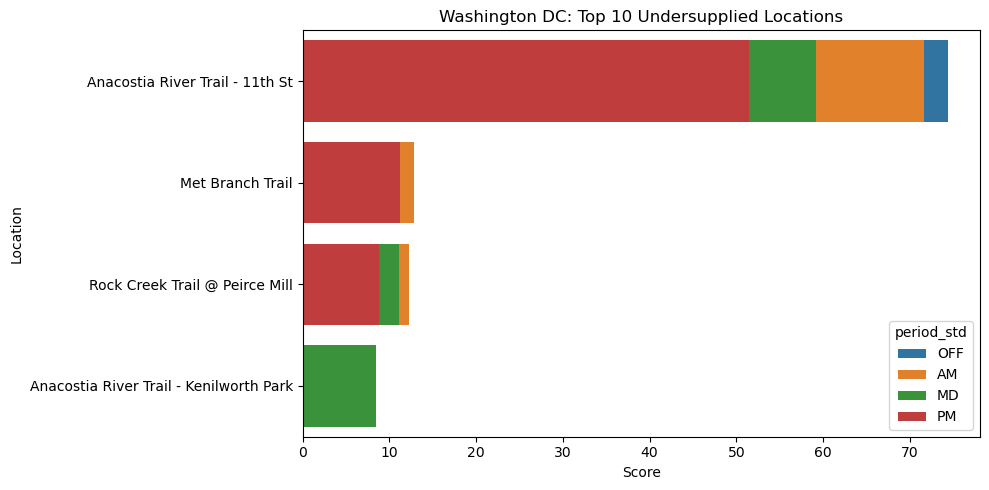

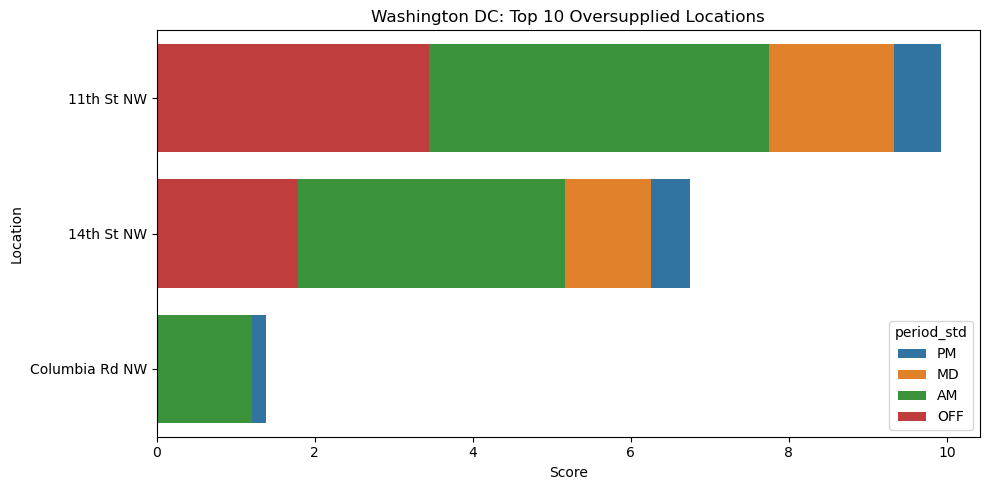

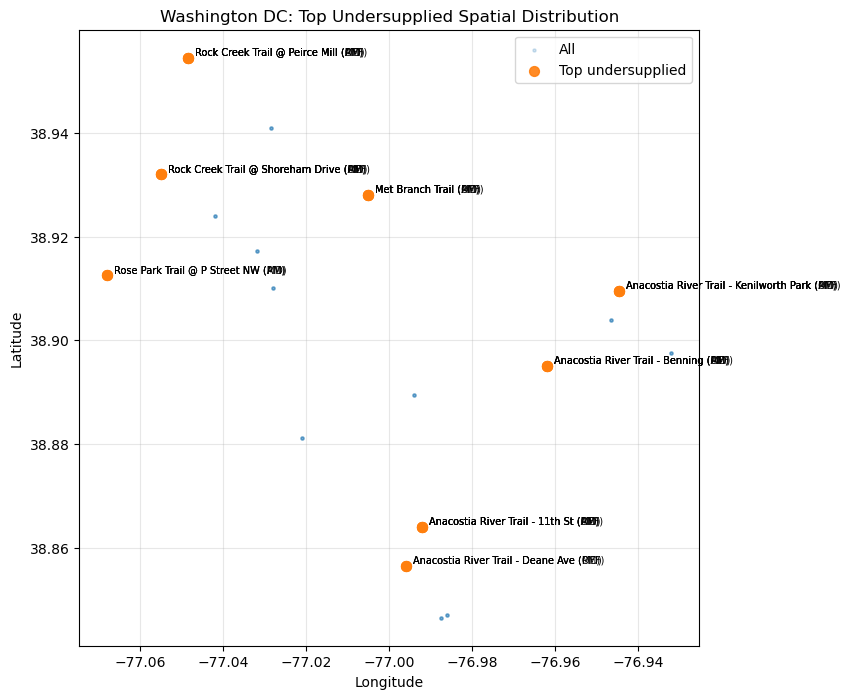

In [29]:
# --------------------------------------------------
# 1. Initialize DC Engine
# --------------------------------------------------

dc_engine = RepositioningMasterEngine(
    df_enriched=dc_nexus.merged_data,   # enriched DC matched hourly data
    city_name="Washington DC",
    unmatched_ped=None,                 # DC had 0 unmatched counters
    accessibility=dc_access             # the access summary you computed
)

# --------------------------------------------------
# 2. Build Profiles
# --------------------------------------------------

dc_profiles = dc_engine.build_location_profiles(
    gap_hi=1.0, 
    gap_lo=-1.0, 
    min_obs=3
)

# --------------------------------------------------
# 3. Ranking tables
# --------------------------------------------------

dc_under = dc_engine.rank_undersupplied(top_n=15)
dc_over  = dc_engine.rank_oversupplied(top_n=15)
dc_new   = dc_engine.rank_new_station_candidates(ped_quantile=0.9)

print("=== DC Undersupplied ===")
print(dc_engine.format_table(dc_under).to_markdown())

print("\n=== DC Oversupplied ===")
print(dc_engine.format_table(dc_over).to_markdown())

print("\n=== DC New Station Candidates ===")
if not dc_new.empty:
    print(dc_new.head(10).round(2).to_markdown())
else:
    print("No unmatched pedestrian counters exceed threshold.")

# --------------------------------------------------
# 4. Visualizations
# --------------------------------------------------

dc_engine.plot_top_locations(mode="undersupplied", top_n=10)
dc_engine.plot_top_locations(mode="oversupplied", top_n=10)
dc_engine.plot_map(mode="undersupplied", top_n=30)



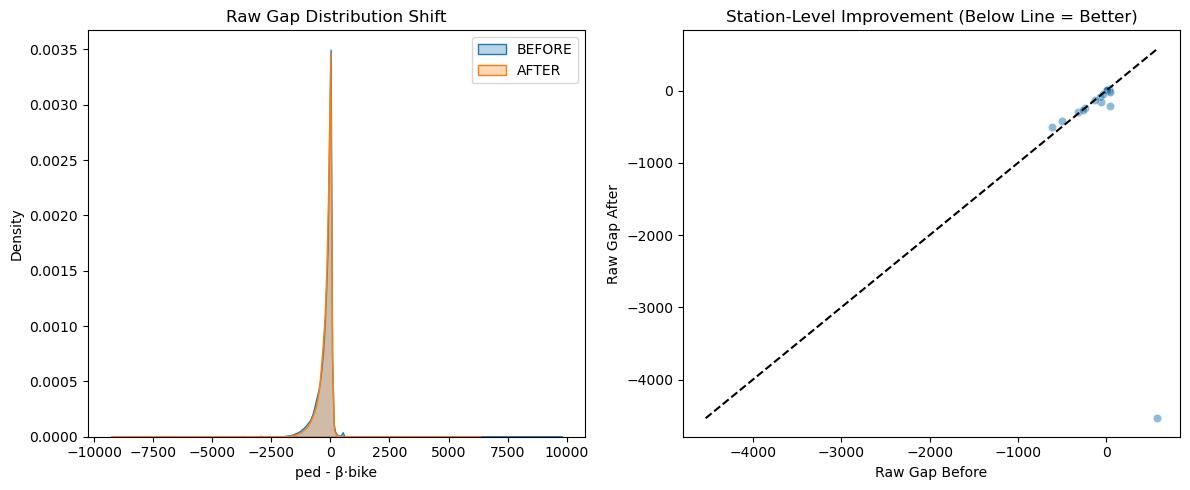

=== COVERAGE SUMMARY ===
Severe Undersupply Before: 0.0966
Severe Undersupply After: 0.0619
Severe Oversupply Before: 0.0999
Severe Oversupply After: 0.0836
Misallocation Index Before: 243.0400
Misallocation Index After: 235.8231
Bike Gini Before: 0.6045
Bike Gini After: 0.6056

=== TOP LOCATIONS WITH IMPROVEMENT ===
| location                                |   raw_gap_reduction |   gap_before |   gap_after |
|:----------------------------------------|--------------------:|-------------:|------------:|
| Anacostia River Trail - 11th St         |      5110.91        |    577.491   | -4533.42    |
| Anacostia River Trail - Kenilworth Park |       250.329       |     38.7125  |  -211.616   |
| Met Branch Trail                        |        88.7068      |    -65.6608  |  -154.368   |
| Rock Creek Trail @ Peirce Mill          |        51.8031      |     37.6727  |   -14.1305  |
| Anacostia River Trail - Benning         |        32.9361      |     32.5684  |    -0.36774 |
| Rock Creek Tra

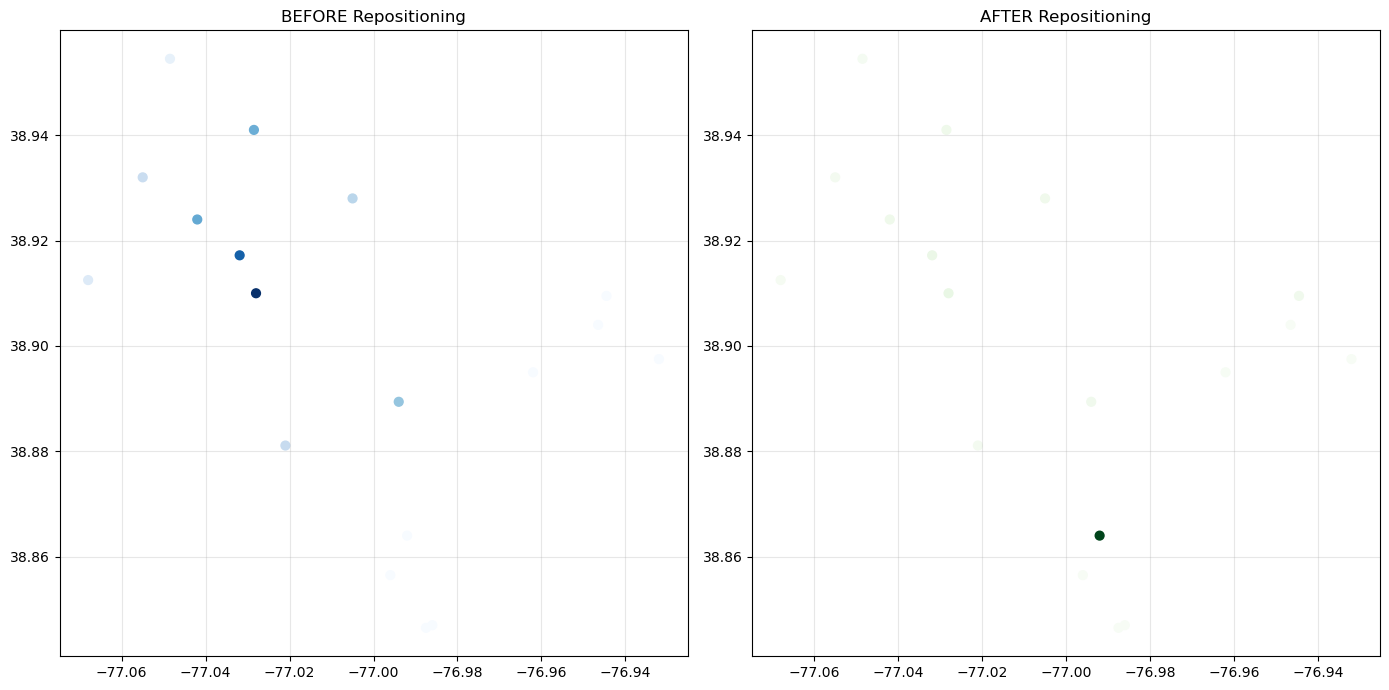

In [34]:
# Always operate on a clean, aligned index
df_original = dc_engine.df.reset_index(drop=True)

# Compute reallocation
realloc = dc_engine.recommended_reallocation(df_original).reset_index(drop=True)

# Apply transformation
df_after = df_original.copy()
df_after["bike"] = df_original["bike"] + realloc
df_after["bike"] = df_after["bike"].clip(lower=0)

# Coverage evaluation
summary, improvements = dc_engine.coverage_improvement_panel(df_after)

print("=== COVERAGE SUMMARY ===")
for k, v in summary.items():
    print(f"{k}: {v:.4f}")

print("\n=== TOP LOCATIONS WITH IMPROVEMENT ===")
print(improvements.to_markdown())

dc_engine.plot_before_after_map(df_after)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Academic styling
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 150

class DatasetIntroductionSuite:
    """
    Generates publication-ready tables and figures for the Datasets section.
    """
    
    def __init__(self, nyc_ped_raw, nyc_bike_raw, dc_ped_clean, dc_bike_raw):
        """
        Args:
            nyc_ped_raw: NYC pedestrian counts (wide format, pre-processing)
            nyc_bike_raw: NYC CitiBike raw trip data
            dc_ped_clean: DC pedestrian counts (already processed with datetime)
            dc_bike_raw: DC Capital Bikeshare raw trip data
        """
        self.nyc_ped = nyc_ped_raw
        self.nyc_bike = nyc_bike_raw
        self.dc_ped = dc_ped_clean
        self.dc_bike = dc_bike_raw
    
    # ==========================================
    # TABLE 1: Dataset Overview Summary
    # ==========================================
    def generate_table1_overview(self):
        """
        Creates Table 1: Comparative Dataset Characteristics
        This is your "at-a-glance" table that shows the fundamental differences.
        """
        print("\n" + "="*80)
        print("TABLE 1: Dataset Characteristics")
        print("="*80)
        
        # NYC Pedestrian Stats
        nyc_ped_locations = self.nyc_ped.shape[0] if 'Loc' in self.nyc_ped.columns else len(self.nyc_ped)
        nyc_ped_temporal = "Bi-Annual (May, Sept/Oct)"
        nyc_ped_years = "2022-2024"
        
        # NYC Bike Stats
        self.nyc_bike['started_at'] = pd.to_datetime(self.nyc_bike['started_at'])
        nyc_bike_trips = len(self.nyc_bike)
        nyc_bike_stations = self.nyc_bike['start_station_name'].nunique()
        nyc_bike_dates = f"{self.nyc_bike['started_at'].min().strftime('%Y-%m')} to {self.nyc_bike['started_at'].max().strftime('%Y-%m')}"
        
        # DC Pedestrian Stats
        dc_ped_locations = self.dc_ped['Station'].nunique()
        dc_ped_temporal = "Continuous Hourly"
        dc_ped_records = len(self.dc_ped)
        dc_ped_dates = f"{self.dc_ped['datetime'].min().strftime('%Y-%m')} to {self.dc_ped['datetime'].max().strftime('%Y-%m')}"
        
        # DC Bike Stats
        self.dc_bike['started_at'] = pd.to_datetime(self.dc_bike['started_at'], format='mixed')
        dc_bike_trips = len(self.dc_bike)
        dc_bike_stations = self.dc_bike['start_station_name'].nunique()
        dc_bike_dates = f"{self.dc_bike['started_at'].min().strftime('%Y-%m')} to {self.dc_bike['started_at'].max().strftime('%Y-%m')}"
        
        # Build comparison table
        table_data = {
            'Characteristic': [
                'Data Type',
                'Temporal Resolution',
                'Spatial Coverage',
                'Sample Size',
                'Time Period',
                'Collection Method'
            ],
            'NYC Pedestrian': [
                'Manual Counts',
                'Bi-Annual Snapshots (3 periods/day)',
                f'{nyc_ped_locations} street segments',
                f'{nyc_ped_locations} locations × ~6 surveys',
                nyc_ped_years,
                'NYC DOT field surveys'
            ],
            'NYC Bikeshare': [
                'Trip Records',
                'Continuous (trip-level)',
                f'{nyc_bike_stations} stations',
                f'{nyc_bike_trips:,} trips',
                nyc_bike_dates,
                'Citibike API'
            ],
            'DC Pedestrian': [
                'Automated Counters',
                'Continuous Hourly',
                f'{dc_ped_locations} trail/street locations',
                f'{dc_ped_records:,} hourly observations',
                dc_ped_dates,
                'Infrared/Pneumatic sensors'
            ],
            'DC Bikeshare': [
                'Trip Records',
                'Continuous (trip-level)',
                f'{dc_bike_stations} stations',
                f'{dc_bike_trips:,} trips',
                dc_bike_dates,
                'Capital Bikeshare API'
            ]
        }
        
        df_table = pd.DataFrame(table_data)
        print(df_table.to_string(index=False))
        print("\n")
        
        return df_table
    
    # ==========================================
    # FIGURE 1: Temporal Coverage Comparison
    # ==========================================
    def plot_temporal_coverage(self):
        """
        Visual timeline showing the "snapshot vs continuous" difference.
        This is crucial for explaining the methodological contrast.
        """
        fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
        
        # --- NYC Timeline (Discrete Snapshots) ---
        ax1 = axes[0]
        
        # Parse NYC dates from column names (e.g., 'May22_AM')
        import re
        count_cols = [c for c in self.nyc_ped.columns if re.match(r'^[A-Za-z]+\d{2}_[A-Za-z]+$', c)]
        
        nyc_dates = []
        for col in count_cols:
            match = re.match(r'([A-Za-z]+)(\d{2})_', col)
            if match:
                month_str, year_str = match.groups()
                month_map = {'May': 5, 'Jun': 6, 'June': 6, 'Sept': 9, 'Oct': 10}
                if month_str in month_map:
                    date = pd.Timestamp(year=2000 + int(year_str), month=month_map[month_str], day=15)
                    nyc_dates.append(date)
        
        nyc_dates = sorted(set(nyc_dates))
        
        # Plot NYC as discrete points
        ax1.scatter(nyc_dates, [1]*len(nyc_dates), s=200, color='crimson', 
                    marker='|', linewidths=3, label='Survey Days')
        ax1.set_ylim(0.5, 1.5)
        ax1.set_yticks([1])
        ax1.set_yticklabels(['NYC\nPedestrian'])
        ax1.set_title('A. NYC Pedestrian Data: Bi-Annual Snapshots', fontsize=12, weight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        ax1.legend(loc='upper right')
        
        # --- DC Timeline (Continuous Coverage) ---
        ax2 = axes[1]
        
        # Group DC by day for visualization
        self.dc_ped['date'] = pd.to_datetime(self.dc_ped['datetime']).dt.date
        daily_counts = self.dc_ped.groupby('date').size().reset_index(name='obs')
        daily_counts['date'] = pd.to_datetime(daily_counts['date'])
        
        # Plot as continuous bar/line
        ax2.fill_between(daily_counts['date'], 0, 1, alpha=0.6, color='steelblue', 
                         label='Continuous Monitoring')
        ax2.set_ylim(0, 1.5)
        ax2.set_yticks([0.5])
        ax2.set_yticklabels(['DC\nPedestrian'])
        ax2.set_title('B. DC Pedestrian Data: Continuous Hourly Monitoring', fontsize=12, weight='bold')
        ax2.set_xlabel('Time Period', fontsize=11)
        ax2.grid(True, alpha=0.3, axis='x')
        ax2.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    # ==========================================
    # FIGURE 2: Spatial Density Comparison
    # ==========================================
    def plot_spatial_density(self):
        """
        Shows the "sparse vs dense" contrast between pedestrian and bikeshare networks.
        """
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # --- NYC ---
        ax1 = axes[0]
        
        nyc_ped_count = self.nyc_ped.shape[0]
        nyc_bike_count = self.nyc_bike['start_station_name'].nunique()
        
        bars1 = ax1.bar(['Pedestrian\nCounters', 'Bikeshare\nStations'], 
                        [nyc_ped_count, nyc_bike_count],
                        color=['crimson', 'steelblue'], alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Number of Locations', fontsize=11)
        ax1.set_title('NYC: Network Density', fontsize=12, weight='bold')
        ax1.bar_label(bars1, fmt='%d', fontsize=10)
        ax1.set_ylim(0, max(nyc_ped_count, nyc_bike_count) * 1.2)
        
        # Add ratio annotation
        ratio_nyc = nyc_bike_count / nyc_ped_count
        ax1.text(0.5, 0.95, f'Ratio: {ratio_nyc:.1f}:1\n(Bike:Ped)', 
                 transform=ax1.transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # --- DC ---
        ax2 = axes[1]
        
        dc_ped_count = self.dc_ped['Station'].nunique()
        dc_bike_count = self.dc_bike['start_station_name'].nunique()
        
        bars2 = ax2.bar(['Pedestrian\nCounters', 'Bikeshare\nStations'], 
                        [dc_ped_count, dc_bike_count],
                        color=['crimson', 'steelblue'], alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Number of Locations', fontsize=11)
        ax2.set_title('DC: Network Density', fontsize=12, weight='bold')
        ax2.bar_label(bars2, fmt='%d', fontsize=10)
        ax2.set_ylim(0, max(dc_ped_count, dc_bike_count) * 1.2)
        
        ratio_dc = dc_bike_count / dc_ped_count
        ax2.text(0.5, 0.95, f'Ratio: {ratio_dc:.1f}:1\n(Bike:Ped)', 
                 transform=ax2.transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    # ==========================================
    # FIGURE 3: Data Structure Comparison
    # ==========================================
    def plot_data_structure_gantt(self):
        """
        A Gantt-style chart showing measurement windows for each dataset.
        Emphasizes the "3 snapshots per day" vs "24 hours continuous" difference.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Define measurement windows
        datasets = ['NYC Ped\n(Bi-Annual)', 'NYC Bike\n(Continuous)', 
                    'DC Ped\n(Continuous)', 'DC Bike\n(Continuous)']
        
        # NYC Pedestrian: 3 discrete periods per survey day
        y_pos = 3
        periods = [(7, 10, 'AM'), (11, 14, 'MD'), (16, 20, 'PM')]
        for start, end, label in periods:
            ax.barh(y_pos, end-start, left=start, height=0.6, 
                   color='crimson', alpha=0.7, edgecolor='darkred', linewidth=1.5)
            ax.text((start+end)/2, y_pos, label, ha='center', va='center', 
                   fontsize=9, weight='bold', color='white')
        
        # NYC Bike: Full continuous
        y_pos = 2
        ax.barh(y_pos, 24, left=0, height=0.6, 
               color='steelblue', alpha=0.5, edgecolor='navy', linewidth=1.5)
        ax.text(12, y_pos, 'All Hours', ha='center', va='center', 
               fontsize=9, weight='bold', color='white')
        
        # DC Pedestrian: Full continuous
        y_pos = 1
        ax.barh(y_pos, 24, left=0, height=0.6, 
               color='crimson', alpha=0.5, edgecolor='darkred', linewidth=1.5)
        ax.text(12, y_pos, 'All Hours', ha='center', va='center', 
               fontsize=9, weight='bold', color='white')
        
        # DC Bike: Full continuous
        y_pos = 0
        ax.barh(y_pos, 24, left=0, height=0.6, 
               color='steelblue', alpha=0.5, edgecolor='navy', linewidth=1.5)
        ax.text(12, y_pos, 'All Hours', ha='center', va='center', 
               fontsize=9, weight='bold', color='white')
        
        ax.set_yticks(range(4))
        ax.set_yticklabels(datasets)
        ax.set_xlabel('Hour of Day', fontsize=11)
        ax.set_xlim(0, 24)
        ax.set_xticks(range(0, 25, 3))
        ax.set_title('Figure 3: Daily Temporal Coverage by Dataset', fontsize=12, weight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    # ==========================================
    # TABLE 2: Sample Data Preview
    # ==========================================
    def generate_table2_sample_records(self):
        """
        Shows actual data structure - helps readers understand the raw format.
        """
        print("\n" + "="*80)
        print("TABLE 2: Sample Data Records (First 3 rows per dataset)")
        print("="*80)
        
        print("\nA. NYC Pedestrian (Wide Format - Showing location + 3 survey columns)")
        nyc_ped_sample = self.nyc_ped[['Loc', 'Street_Nam'] + 
                                      [c for c in self.nyc_ped.columns if 'May22' in c][:3]].head(3)
        print(nyc_ped_sample.to_string(index=False))
        
        print("\n\nB. NYC CitiBike Trips")
        nyc_bike_sample = self.nyc_bike[['started_at', 'start_station_name', 
                                          'end_station_name', 'rideable_type']].head(3)
        print(nyc_bike_sample.to_string(index=False))
        
        print("\n\nC. DC Pedestrian (Continuous Hourly)")
        dc_ped_sample = self.dc_ped[['datetime', 'Station', 'Counts', 'hour']].head(3)
        print(dc_ped_sample.to_string(index=False))
        
        print("\n\nD. DC Capital Bikeshare Trips")
        dc_bike_sample = self.dc_bike[['started_at', 'start_station_name', 
                                        'end_station_name', 'rideable_type']].head(3)
        print(dc_bike_sample.to_string(index=False))
        print("\n")
    
    # ==========================================
    # FIGURE 4: Volume Distribution Comparison
    # ==========================================
    def plot_volume_distributions(self):
        """
        Shows typical volume ranges for each dataset - helps establish scale.
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # NYC Pedestrian (need to melt first)
        import re
        count_cols = [c for c in self.nyc_ped.columns if re.match(r'^[A-Za-z]+\d{2}_[A-Za-z]+$', c)]
        nyc_ped_values = self.nyc_ped[count_cols].values.flatten()
        nyc_ped_values = nyc_ped_values[~np.isnan(nyc_ped_values)]
        
        axes[0,0].hist(nyc_ped_values, bins=50, color='crimson', alpha=0.7, edgecolor='black')
        axes[0,0].set_title('A. NYC Pedestrian Counts', fontsize=11, weight='bold')
        axes[0,0].set_xlabel('Pedestrians per Period')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(np.median(nyc_ped_values), color='red', linestyle='--', 
                         label=f'Median: {np.median(nyc_ped_values):.0f}')
        axes[0,0].legend()
        
        # NYC Bike (daily station volumes)
        self.nyc_bike['date'] = pd.to_datetime(self.nyc_bike['started_at']).dt.date
        nyc_bike_daily = self.nyc_bike.groupby(['start_station_name', 'date']).size()
        
        axes[0,1].hist(nyc_bike_daily, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0,1].set_title('B. NYC Bikeshare Daily Station Activity', fontsize=11, weight='bold')
        axes[0,1].set_xlabel('Trips per Station per Day')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(np.median(nyc_bike_daily), color='navy', linestyle='--',
                         label=f'Median: {np.median(nyc_bike_daily):.0f}')
        axes[0,1].legend()
        
        # DC Pedestrian
        axes[1,0].hist(self.dc_ped['Counts'], bins=50, color='crimson', alpha=0.7, edgecolor='black')
        axes[1,0].set_title('C. DC Pedestrian Hourly Counts', fontsize=11, weight='bold')
        axes[1,0].set_xlabel('Pedestrians per Hour')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].axvline(np.median(self.dc_ped['Counts']), color='red', linestyle='--',
                         label=f'Median: {np.median(self.dc_ped["Counts"]):.0f}')
        axes[1,0].legend()
        
        # DC Bike
        self.dc_bike['date'] = pd.to_datetime(self.dc_bike['started_at']).dt.date
        dc_bike_daily = self.dc_bike.groupby(['start_station_name', 'date']).size()
        
        axes[1,1].hist(dc_bike_daily, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[1,1].set_title('D. DC Bikeshare Daily Station Activity', fontsize=11, weight='bold')
        axes[1,1].set_xlabel('Trips per Station per Day')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].axvline(np.median(dc_bike_daily), color='navy', linestyle='--',
                         label=f'Median: {np.median(dc_bike_daily):.0f}')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    # ==========================================
    # MASTER FUNCTION: Generate All
    # ==========================================
    def generate_all_intro_materials(self):
        """
        Runs all table/figure generation functions in proper order.
        """
        print("\n" + "="*80)
        print("GENERATING DATASET INTRODUCTION MATERIALS")
        print("="*80)
        
        # Tables
        table1 = self.generate_table1_overview()
        self.generate_table2_sample_records()
        
        # Figures
        fig1 = self.plot_temporal_coverage()
        fig2 = self.plot_spatial_density()
        fig3 = self.plot_data_structure_gantt()
        fig4 = self.plot_volume_distributions()
        
        print("\n✓ All introduction materials generated successfully!")
        print("  - 2 Tables (overview + samples)")
        print("  - 4 Figures (temporal, spatial, structure, distributions)")
        
        return {
            'table1': table1,
            'fig1': fig1,
            'fig2': fig2, 
            'fig3': fig3,
            'fig4': fig4
        }


# ==========================================
# USAGE EXAMPLE
# ==========================================
nyc_ped_df = pd.read_csv('../../local/Data/nyc_foot/Bi-Annual_Pedestrian_Counts.csv')
nyc_bike_df = pd.read_csv('../../local/Data/PROCESSED/nyc/ped/citibike_selected_months_combined.csv') 





GENERATING DATASET INTRODUCTION MATERIALS

TABLE 1: Dataset Characteristics
     Characteristic                      NYC Pedestrian           NYC Bikeshare               DC Pedestrian            DC Bikeshare
          Data Type                       Manual Counts            Trip Records          Automated Counters            Trip Records
Temporal Resolution Bi-Annual Snapshots (3 periods/day) Continuous (trip-level)           Continuous Hourly Continuous (trip-level)
   Spatial Coverage                 114 street segments           2374 stations   18 trail/street locations            887 stations
        Sample Size          114 locations × ~6 surveys        22,914,117 trips 202,963 hourly observations        13,360,583 trips
        Time Period                           2022-2024      2021-01 to 2024-10          2022-01 to 2024-12      2022-01 to 2024-12
  Collection Method               NYC DOT field surveys            Citibike API  Infrared/Pneumatic sensors   Capital Bikeshare API

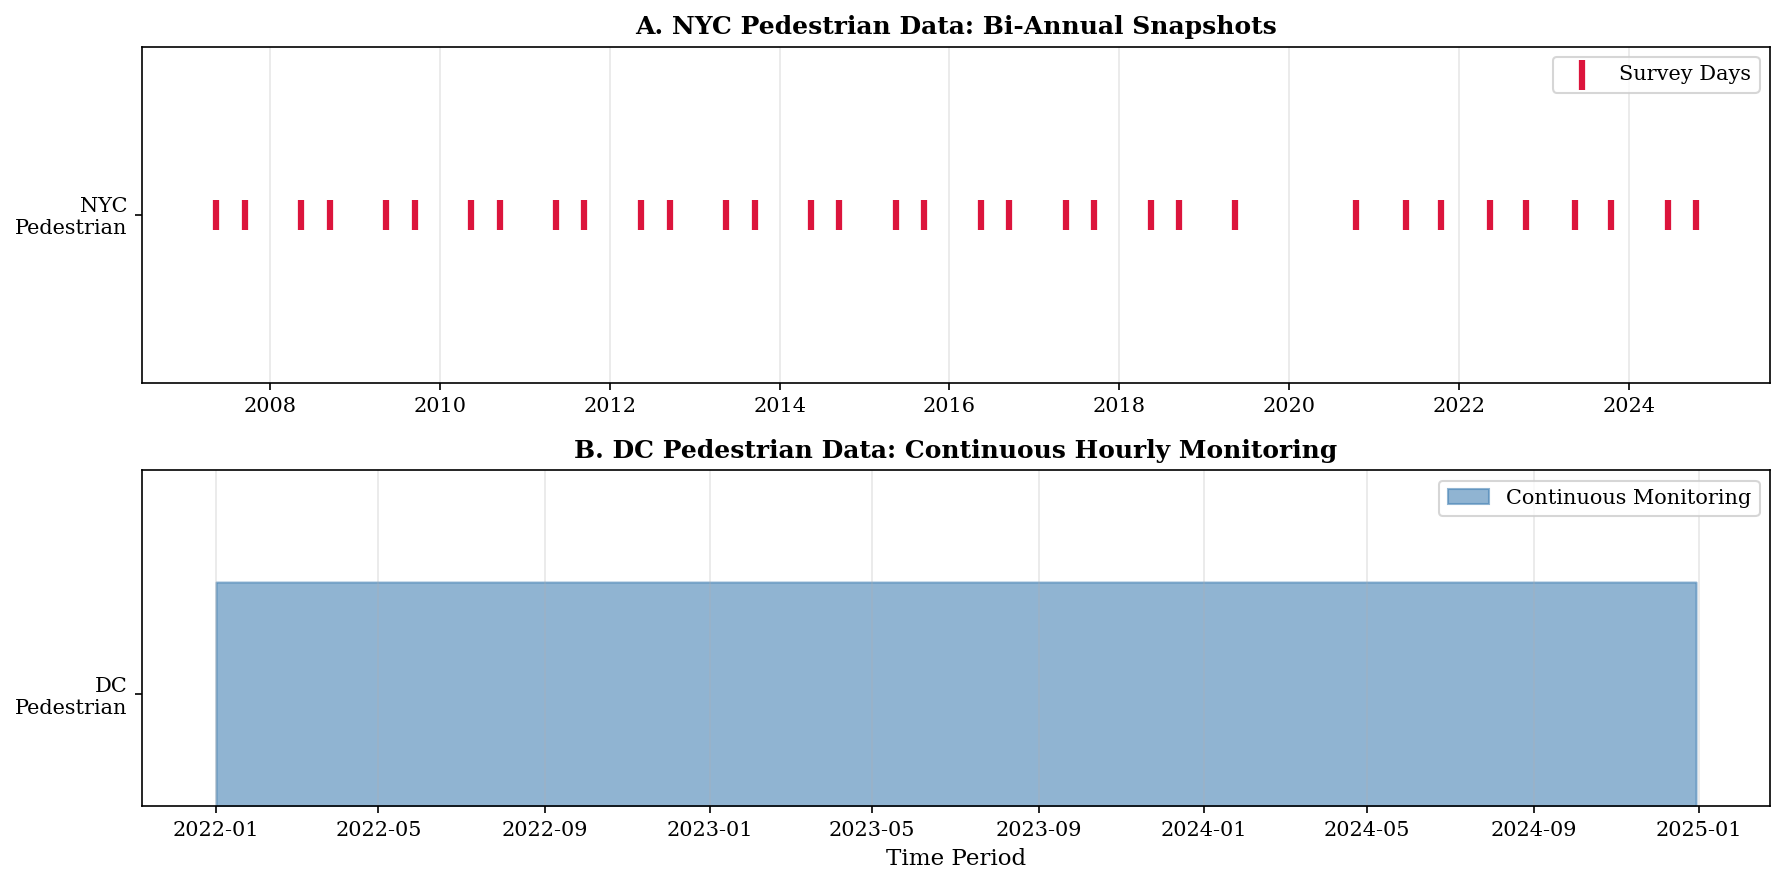

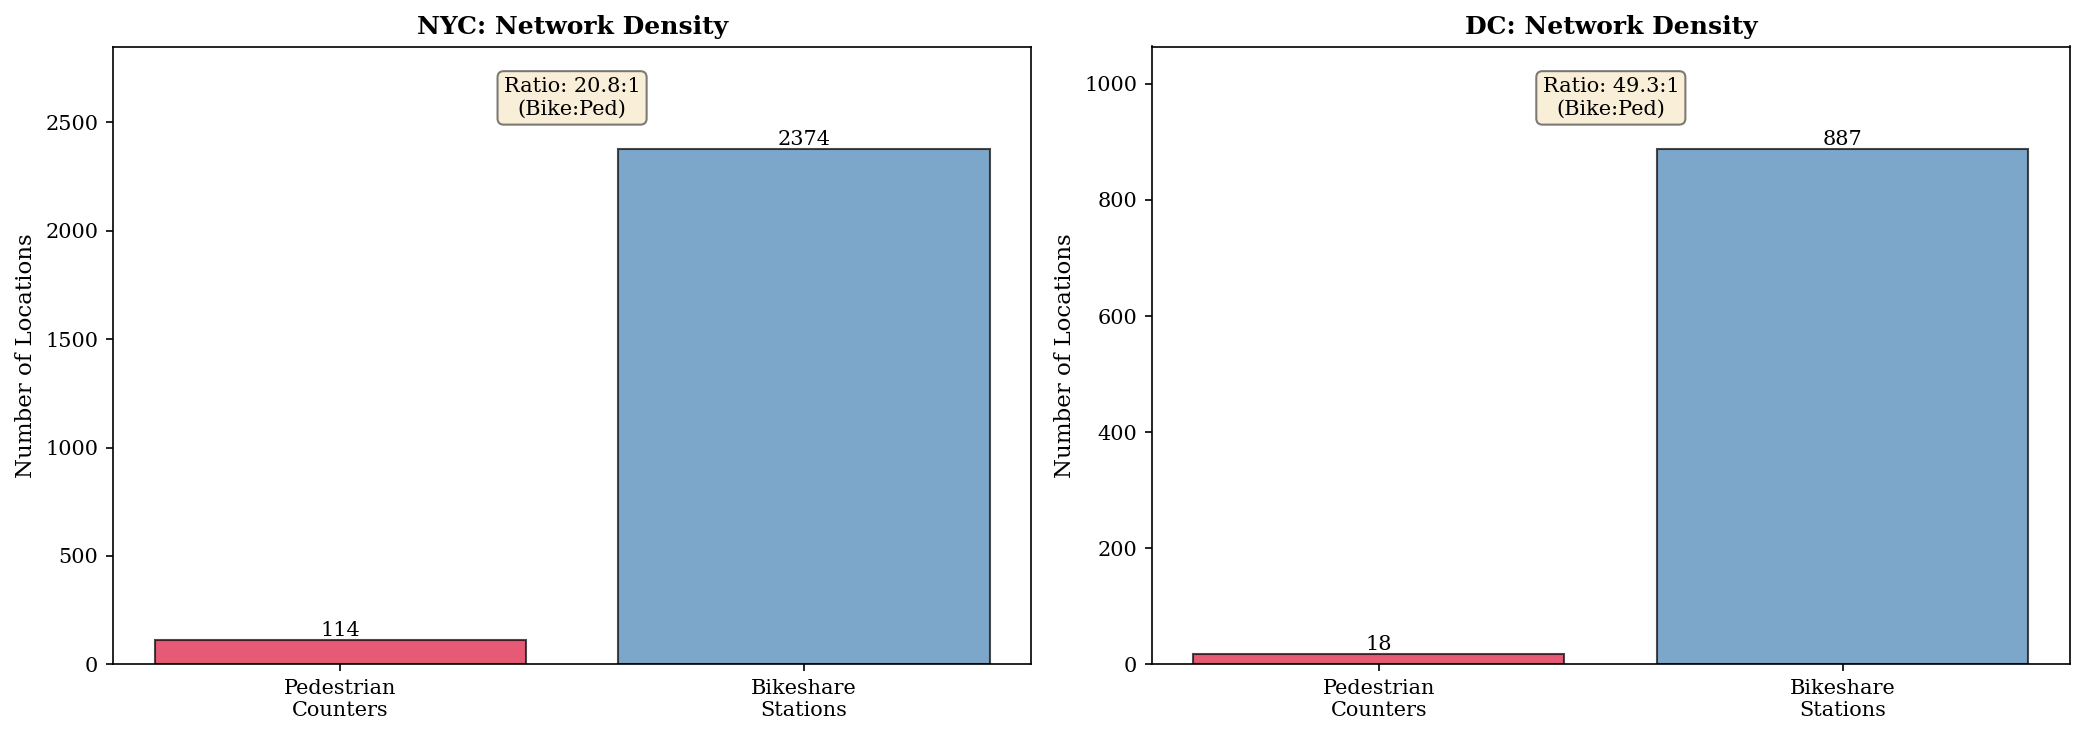

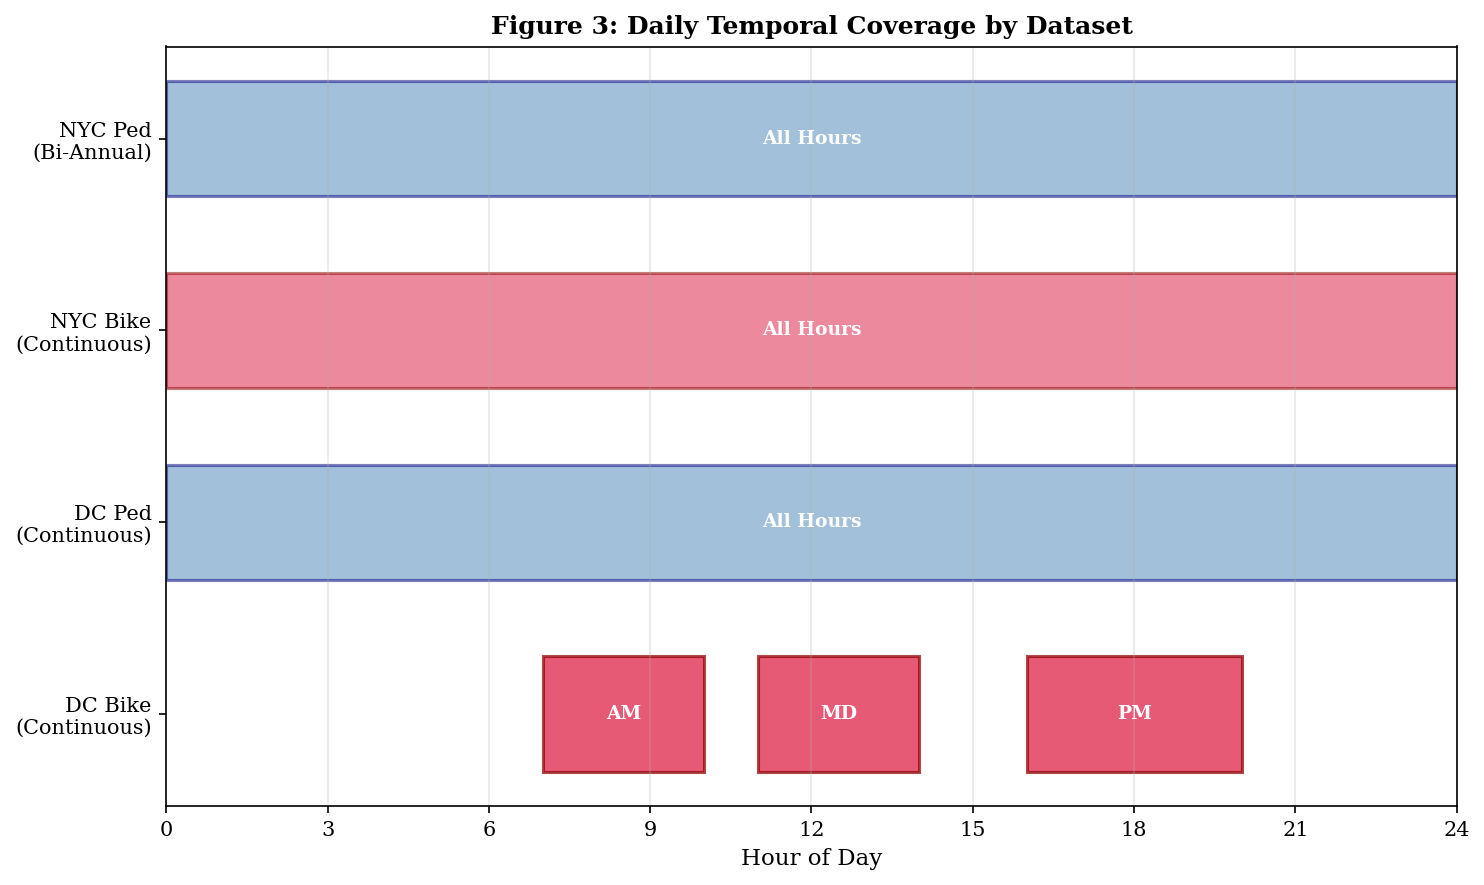

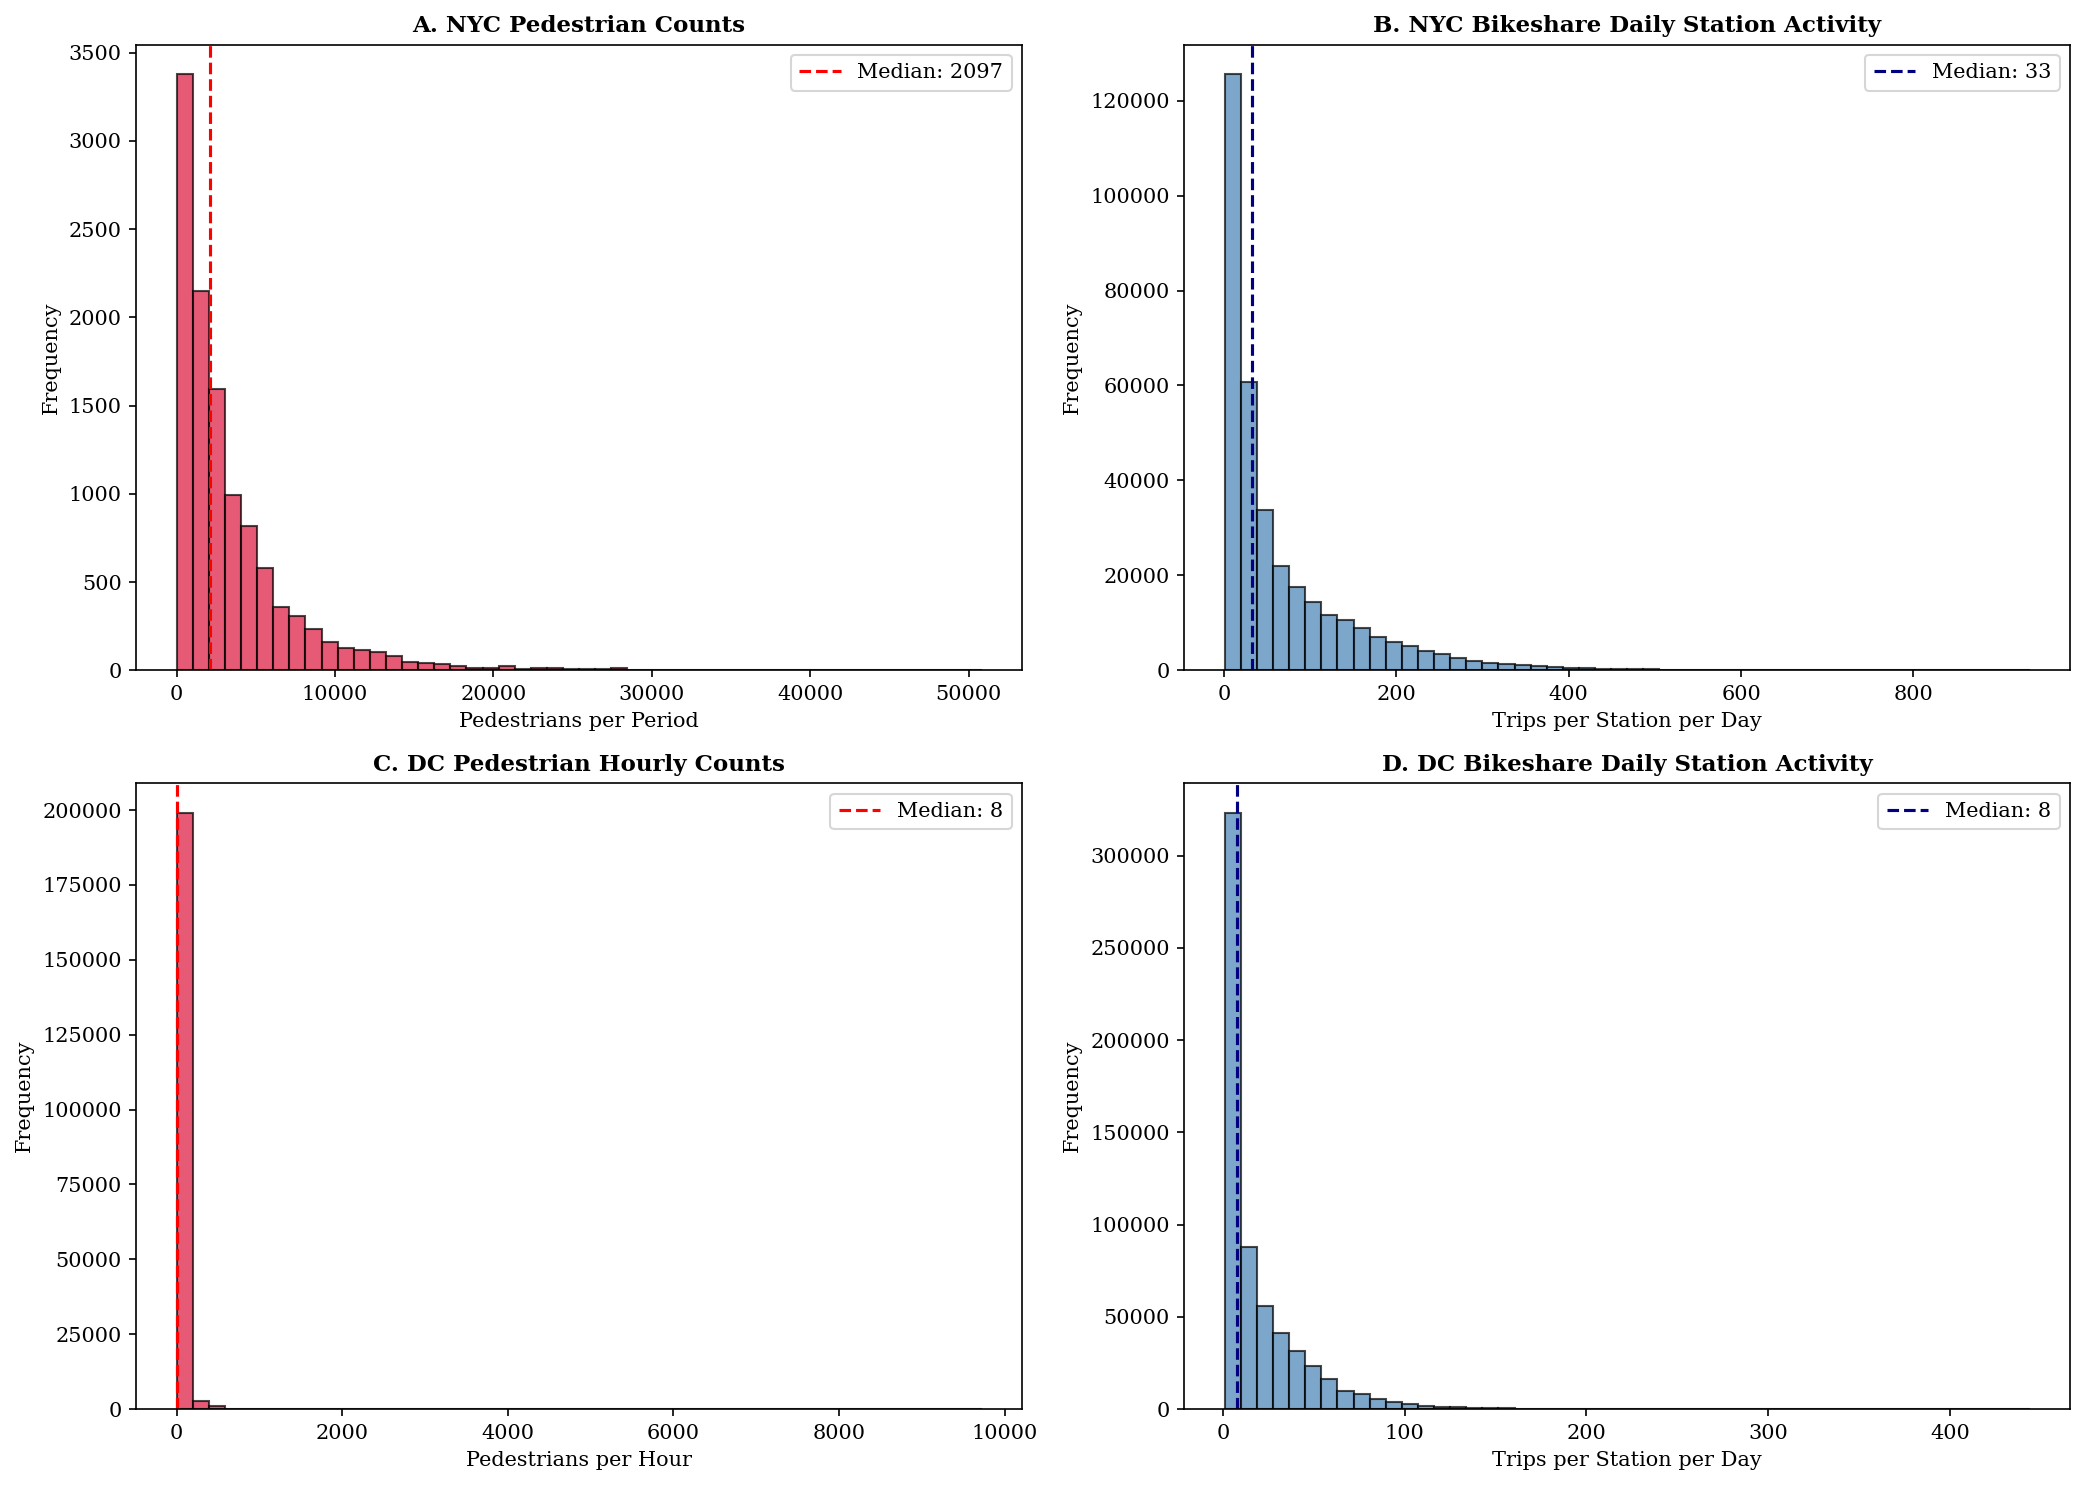


✓ All introduction materials generated successfully!
  - 2 Tables (overview + samples)
  - 4 Figures (temporal, spatial, structure, distributions)

TABLE 1: Dataset Characteristics
     Characteristic                      NYC Pedestrian           NYC Bikeshare               DC Pedestrian            DC Bikeshare
          Data Type                       Manual Counts            Trip Records          Automated Counters            Trip Records
Temporal Resolution Bi-Annual Snapshots (3 periods/day) Continuous (trip-level)           Continuous Hourly Continuous (trip-level)
   Spatial Coverage                 114 street segments           2374 stations   18 trail/street locations            887 stations
        Sample Size          114 locations × ~6 surveys        22,914,117 trips 202,963 hourly observations        13,360,583 trips
        Time Period                           2022-2024      2021-01 to 2024-10          2022-01 to 2024-12      2022-01 to 2024-12
  Collection Method       

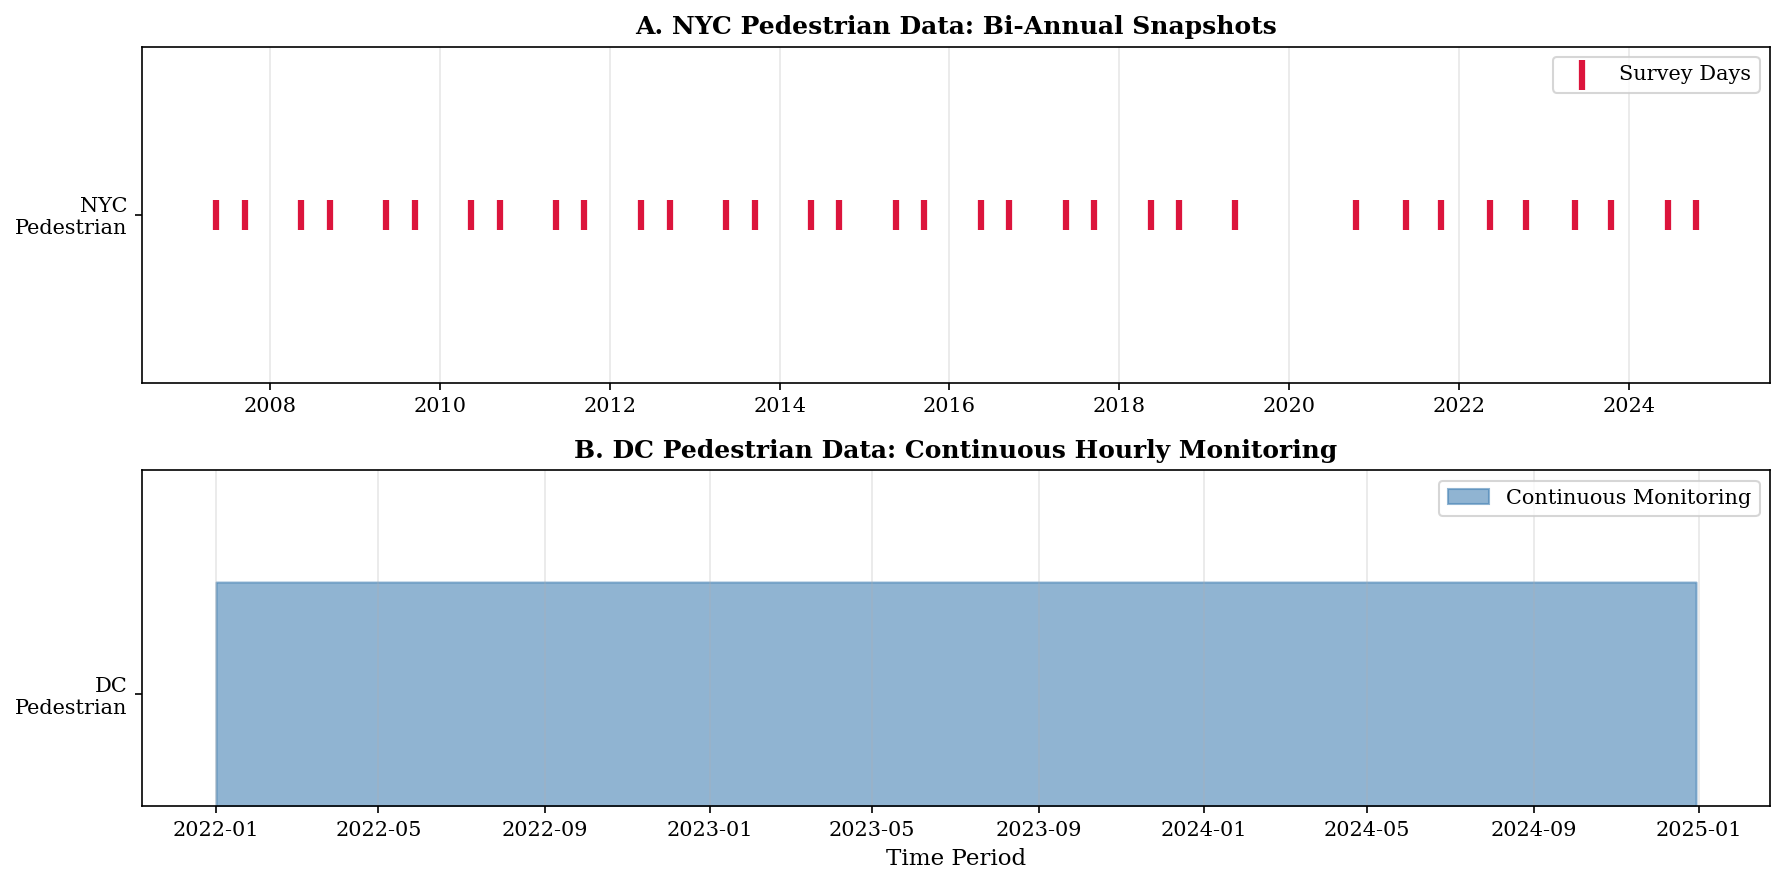

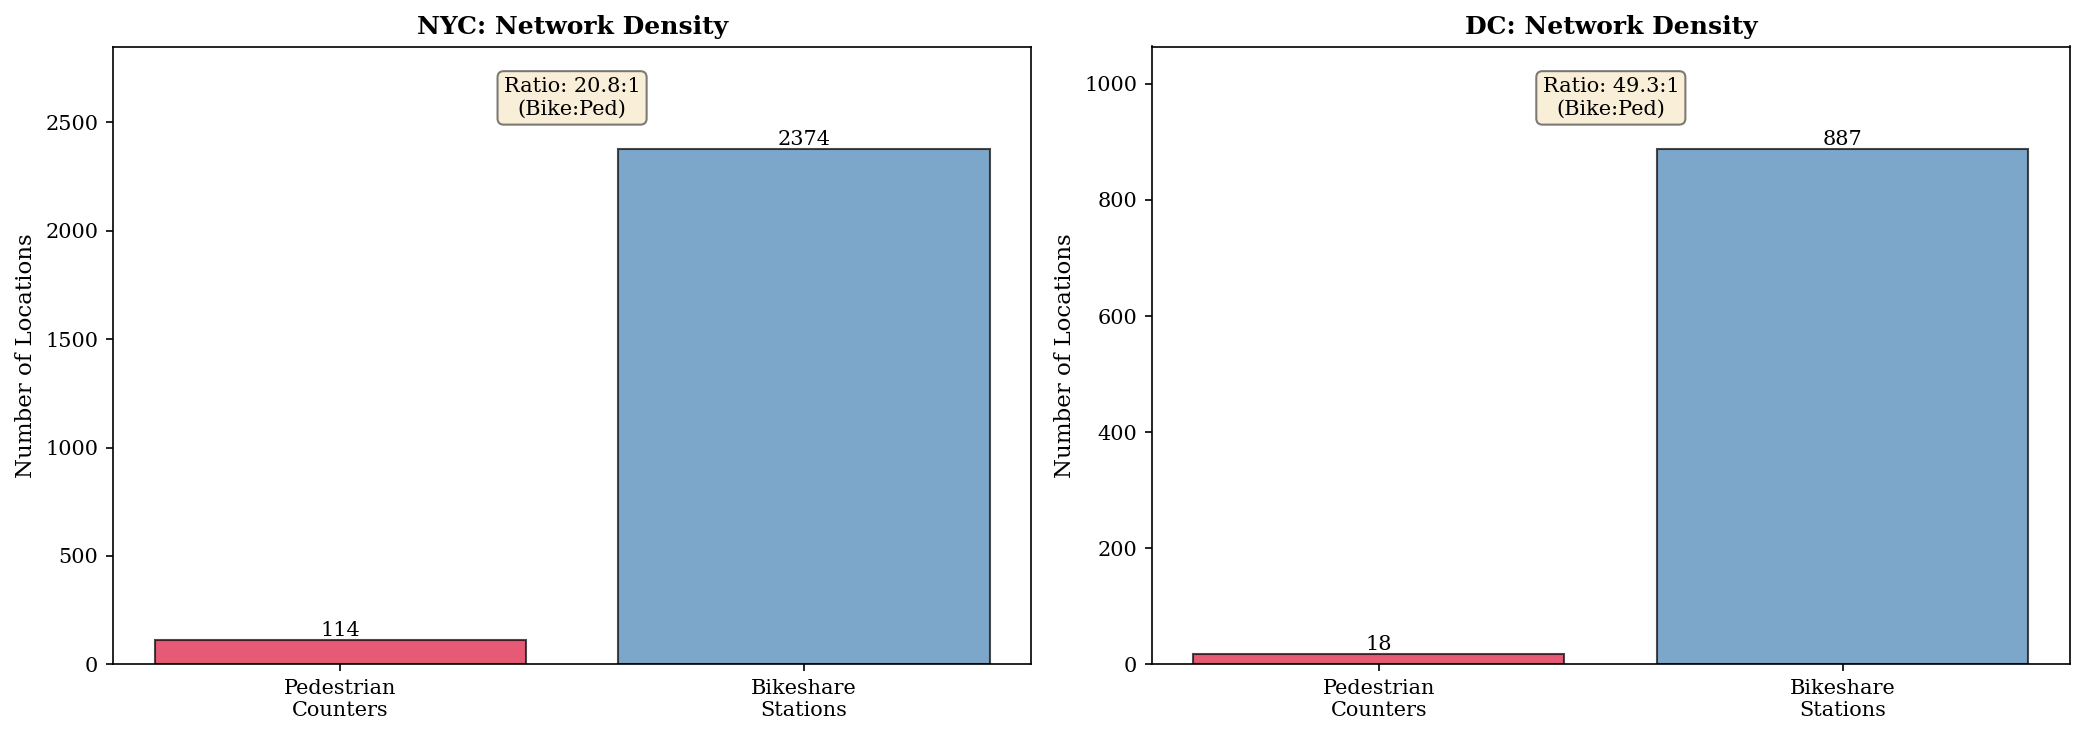

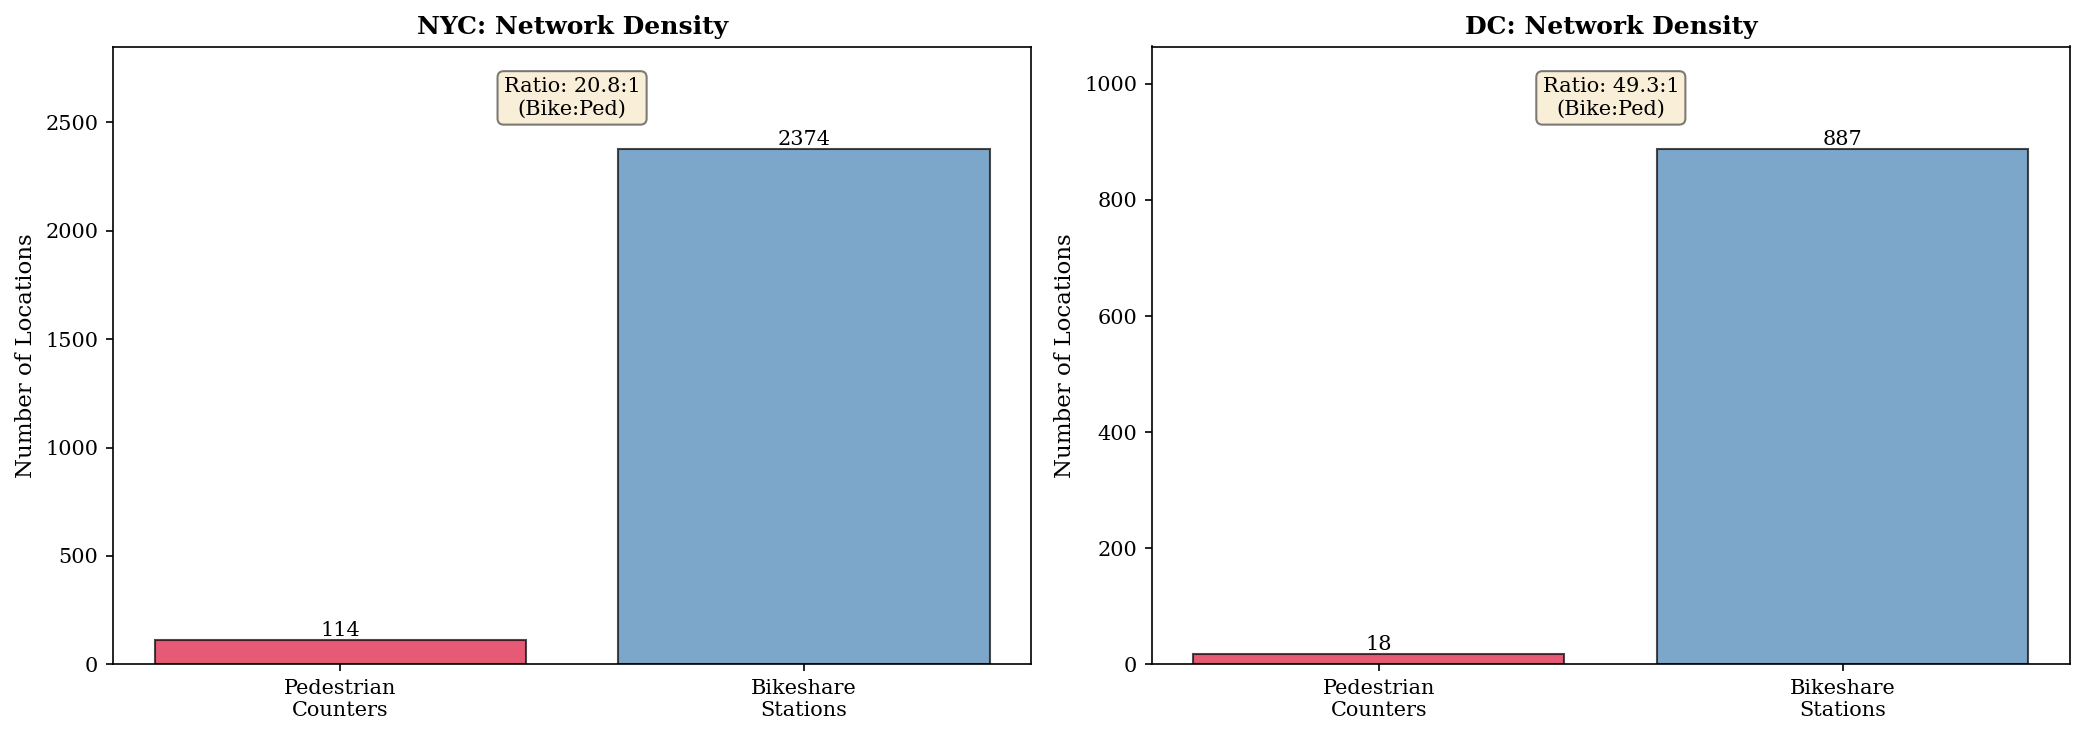

In [8]:

# Initialize with your raw datasets
intro_suite = DatasetIntroductionSuite(
    nyc_ped_raw=nyc_ped_df,      # Wide format from CSV
    nyc_bike_raw=nyc_bike_df,    # Raw trip records
    dc_ped_clean=ped_clean,   # After preprocess_pedestrian()
    dc_bike_raw=dc_bike_df       # Raw trip records
)

# Generate everything at once
results = intro_suite.generate_all_intro_materials()

# Or generate individually:
intro_suite.generate_table1_overview()
intro_suite.plot_temporal_coverage()
intro_suite.plot_spatial_density()